In [1]:
%load_ext autoreload
%autoreload 2
from sklearn.cluster import SpectralClustering as sc
import numpy.random as rand
from numpy.linalg import norm as dist
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from scipy.special import expit
from sklearn.linear_model import Ridge as ridge
from sklearn.linear_model import Lasso as lasso
from sklearn.linear_model import LinearRegression as ols
from sklearn.svm import SVR as kernel_svr
from sklearn.svm import LinearSVR as lin_svr
from sklearn.kernel_ridge import KernelRidge as kernel_ridge

from sklearn.tree import DecisionTreeRegressor as reg_tree
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import AdaBoostRegressor as ada_reg
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from sklearn.model_selection import GridSearchCV

import copy

import statsmodels.api as sm
import statsmodels.formula.api as smf

rmse = lambda x,y: np.power(mse(x,y), 0.5)

import pandas as pd

import multiprocessing
_n_cpu = multiprocessing.cpu_count()
print(_n_cpu)

/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


8


In [2]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as np2ri

robjects.numpy2ri.activate()

from rpy2.robjects.packages import importr
grf = importr('grf')
cf = grf.causal_forest

In [3]:
def count_nans(x):
    assert(type(x) == type(np.ones(1,)))
    return np.sum(np.isnan(x))

In [4]:
star_data = pd.read_csv('STAR_Students_for_Uri.csv')
star_data.columns

Index(['stdntid', 'gender', 'race', 'birthmonth', 'birthday', 'birthyear',
       'gkclasstype', 'gkclasssize', 'gkschid', 'gksurban', 'gktchid',
       'gkfreelunch', 'gktreadss', 'gktmathss', 'gktlistss', 'g1classtype',
       'g1classsize', 'g1schid', 'g1surban', 'g1tchid', 'g1freelunch',
       'g1treadss', 'g1tmathss', 'g1tlistss', 'g2classtype', 'g2classsize',
       'g2schid', 'g2surban', 'g2tchid', 'g2freelunch', 'g2treadss',
       'g2tmathss', 'g2tlistss', 'g3classtype', 'g3classsize', 'g3schid',
       'g3surban', 'g3tchid', 'g3freelunch', 'g3treadss', 'g3tmathss',
       'g3tlangss', 'g3tlistss', 'Unnamed: 43', 'Unnamed: 44'],
      dtype='object')

In [5]:
treatment_filter = np.isfinite(star_data.g1classtype)
outcome_filter = np.isfinite(star_data.g1tlistss + star_data.g1treadss + star_data.g1tmathss)

In [6]:
print('Full data set size     : ', star_data.shape)
print('Removing treatment NaNs: ',  star_data[treatment_filter].shape)
print('Removing outcome NaNs  : ',  star_data[np.logical_and(treatment_filter, outcome_filter)].shape)

Full data set size     :  (11601, 45)
Removing treatment NaNs:  (6829, 45)
Removing outcome NaNs  :  (6322, 45)


In [7]:
# RANDOM FORESTS
reg_parameter_pairs = [(rfr(),{#'max_depth':[None] + list(range(2,11,4)),
                             'min_samples_leaf':list(range(1,10,4)), 
                             'n_estimators':[10, 50, 100, 150, 200, 400]})]

# ADABOOST REGRESSION
reg_parameter_pairs.append((ada_reg(),{'loss':['linear', 'square', 'exponential'],
                                     'n_estimators':[10, 50, 100, 150, 200]}))

# REGRESSION TREES
reg_parameter_pairs.append((reg_tree(),{'max_depth':list(range(4,20,3))}))

# GRADIENT BOOSTED REGRESSION TREES
reg_parameter_pairs.append((gbr(),{'loss':['ls', 'lad', 'huber'],
                                    #'max_depth':list(range(2,7,4)),
                                    'min_samples_leaf':list(range(1,10,4)),
                                    'n_estimators':[10, 50, 100, 200, 400]}))

# # KERNEL RIDGE
# reg_parameter_pairs.append((kernel_ridge(),{'kernel':['poly','rbf','sigmoid'],
#                                              'alpha':[1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]}))
# kernel_ridge?

In [8]:
rfr_reg_parameter_pairs = [(rfr(),{#'max_depth':[None] + list(range(2,11,4)),
                             'min_samples_leaf':list(range(1,11,3)), 
                             'n_estimators':[100, 200]})]

In [9]:
# # OLS
# # linear_reg_parameter_pairs = [(ols(),{'fit_intercept': [True]})]
# linear_reg_parameter_pairs = []
# # LASSO
# linear_reg_parameter_pairs.append((lasso(), {'alpha': np.logspace(-7, 7,8),
#                                              'selection':['random'],
#                                              'max_iter':[500000],
#                                              'tol':[1e-3]}))
# # RIDGE
# linear_reg_parameter_pairs.append((ridge(), {'alpha': np.logspace(-7, 7,8),
#                                              'max_iter':[500000]}))

# # linear SUPPORT VECTOR REGRESSION
# linear_reg_parameter_pairs.append((lin_svr(), {'C': np.logspace(-7, 7,8),
#                                                'max_iter':[500000]}))

In [10]:
# OLS
# linear_reg_parameter_pairs = [(ols(),{'fit_intercept': [True]})]
linear_reg_parameter_pairs = []
# # LASSO
# linear_reg_parameter_pairs.append((lasso(), {'alpha': np.logspace(-6, 6,5),
#                                              'selection':['random'],
#                                              'max_iter':[400000],
#                                              'tol':[1e-3]}))
# # RIDGE
linear_reg_parameter_pairs.append((ridge(), {'alpha':np.logspace(-7, 7,8),
                                             'tol':[1e-3]}))

# # # linear SUPPORT VECTOR REGRESSION
# linear_reg_parameter_pairs.append((lin_svr(), {'C': np.logspace(-6, 6,5),
#                                                'max_iter':[400000],
#                                                'tol':[1e-3]}))

In [11]:
regs = [rfr(n_estimators=i, min_samples_leaf=2) for i in [10, 20, 40, 60, 100, 150, 200]]
regs += [reg_tree(max_depth=i) for i in [5, 10, 20, 30, 40, 50]]
regs += [ada_reg(n_estimators=i) for i in [10, 20, 50, 70, 100, 150, 200]]
regs += [gbr(n_estimators=i) for i in [50, 70, 100, 150, 200]]
regs.extend([kernel_ridge(alpha=alph, kernel=kern) for alph in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5] for kern in ['poly','rbf','sigmoid']])
# regs.extend([kernel_svr(C=c) for c in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5] for kern in ['poly','rbf','sigmoid']])

linear_regs = [ols()] 
linear_regs.extend([lasso(alpha=alph) for alph in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]])
linear_regs.extend([ridge(alpha=alph) for alph in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]])
linear_regs.extend([lin_svr(C=c) for c in [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]])

def get_best_for_data(X, Y, regs, print_flag = False):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
    val_errs = []
    models = []
    for reg in regs:
        model = copy.deepcopy(reg)
        model.fit(x_train, y_train)
        val_errs.append(rmse(y_test, model.predict(x_test)))
        if print_flag:
            print('trying ' + str(model)[:60], val_errs[-1])
        models.append(copy.deepcopy(model))
    min_ind = val_errs.index(min(val_errs))
    print(str(regs[min_ind]), 'val rmse:{}'.format(val_errs[min_ind]))
    return models[min_ind]


def get_best_model_from_gridcv(X, Y, reg_parameter_pairs, print_flag = False, verbose = 0):
    val_errs = []
    models = []
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
    for reg, parameters in reg_parameter_pairs:
        if print_flag:
            print('trying ', str(reg)[:50])
        model = GridSearchCV(reg, parameters, cv=2, refit=True, verbose=verbose, n_jobs = 10)
        model.fit(X,Y)
        val_errs.append(rmse(y_test, model.predict(x_test)))
#         if print_flag:
#             print('trying ' + str(reg)[:60], val_errs[-1])
        models.append(copy.deepcopy(model.best_estimator_))
    min_ind = val_errs.index(min(val_errs))
    if verbose != 0:
        print(str(models[min_ind]), 'val rmse:{}'.format(val_errs[min_ind]))
    return copy.deepcopy(models[min_ind])

In [12]:
def covar_and_interaction_term(x,t):
    assert x.shape[0] == t.shape[0], 'make sure x,t have the same number of samples'
    assert len(t.shape) == 1 or t.shape[1] == 1,'t must have a shape (a,) or (a,1)'
    term_int = np.multiply(x, t.reshape(-1,1))
    return np.hstack((x,t.reshape(-1,1),term_int))

def _to_categorical(X):
    assert(type(X) == type(np.ones((1,))))
    return pd.get_dummies(pd.DataFrame(X.astype(str)), dummy_na=True).values.astype(np.int)

def regress_with_interaction_term(_X, _Y, _T, linear_regs):
    _X_interaction = covar_and_interaction_term(_X, _T)
    _f_best = get_best_for_data(_X_interaction, _Y, linear_regs)
    return copy.deepcopy(_f_best)

In [13]:
cat_covar_columns = ['gender', 'race', 'birthmonth', 'birthday', 'birthyear', 
                     # 'gkschid', 
                     # 'gktchid', 
                     'gkfreelunch',
                     # 'gktreadss', 'gktmathss', 'gktlistss',
                     # 'g1schid', 
                     'g1tchid', 
                     'g1freelunch' ] # 'g1treadss', 'g1tmathss', 'g1tlistss']

_confounding_covar = 'g1surban'

# 'gkclasssize' same as gk and maybe g1
num_covar_columns = [ 'gktreadss', 'gktmathss', 'gktlistss']
Y_columns = [ 'g1treadss', 'g1tmathss', 'g1tlistss']

In [14]:
for name in cat_covar_columns:
    print(name,)
    

gender
race
birthmonth
birthday
birthyear
gkfreelunch
g1tchid
g1freelunch


In [15]:
# for col in cat_covar_columns:
#     if col == 'birthday':
#         continue
#     print(col, len(set(star_data[outcome_filter][col].fillna(-1))))
#     print(star_data[outcome_filter].fillna(-1).groupby(col).size())
star_data[cat_covar_columns + Y_columns][outcome_filter].fillna(-1).corr()


,gender,race,birthmonth,birthday,birthyear,gkfreelunch,g1tchid,g1freelunch,g1treadss,g1tmathss,g1tlistss
gender,1.000000,0.008470,0.005888,0.007640,0.022252,0.029746,0.010995,-0.010638,0.101150,0.001521,-0.006144
race,0.008470,1.000000,-0.005727,-0.000866,0.027945,-0.204308,0.291779,-0.277295,-0.262934,-0.267703,-0.316418
birthmonth,0.005888,-0.005727,1.000000,-0.035776,0.040553,-0.032230,-0.005644,-0.016031,0.006727,-0.003830,-0.006117
birthday,0.007640,-0.000866,-0.035776,1.000000,0.040958,-0.024933,-0.002868,-0.013146,-0.028317,-0.027968,-0.013439
birthyear,0.022252,0.027945,0.040553,0.040958,1.000000,0.033730,-0.021625,0.004971,0.006494,-0.007884,-0.006379
gkfreelunch,0.029746,-0.204308,-0.032230,-0.024933,0.033730,1.000000,-0.011985,0.278325,0.242825,0.212630,0.215343
g1tchid,0.010995,0.291779,-0.005644,-0.002868,-0.021625,-0.011985,1.000000,-0.069965,-0.118471,-0.119555,-0.123606
g1freelunch,-0.010638,-0.277295,-0.016031,-0.013146,0.004971,0.278325,-0.069965,1.000000,0.293404,0.269605,0.286026
g1treadss,0.101150,-0.262934,0.006727,-0.028317,0.006494,0.242825,-0.118471,0.293404,1.000000,0.725071,0.616927
g1tmathss,0.001521,-0.267703,-0.003830,-0.027968,-0.007884,0.212630,-0.119555,0.269605,0.725071,1.000000,0.715495


In [16]:
# all is post-filtering
# CHECKED
T_all = star_data.g1classtype[np.logical_and(treatment_filter, outcome_filter)].values # check
X_all = _to_categorical(star_data[cat_covar_columns][np.logical_and(treatment_filter, outcome_filter)].fillna(0).values[T_all!=3]) #check
Y_cols = star_data[Y_columns][np.logical_and(treatment_filter, outcome_filter)].values[T_all!=3] # check 
urban = star_data.g1surban[np.logical_and(outcome_filter, treatment_filter)].values[T_all!=3] # check 

rural_filter = np.logical_or(urban==1, urban==3) # 1 = inner city, 3 = rural
urban_filter = np.logical_or(urban==2, urban==4) # 2 = suburban, 4 = urban

## FLIPPING AROUND TEMPORARILY
# urban_filter = np.logical_or(urban==1, urban==3) # 1 = inner city, 3 = rural
# rural_filter = np.logical_or(urban==2, urban==4) # 2 = suburban, 4 = urban

T_all = star_data.g1classtype[np.logical_and(treatment_filter, outcome_filter)].values[T_all!=3] # removing 2s from T. check
T_all[T_all == 2] = 0 # check. 3 is control.
Y_all = np.sum(Y_cols, axis=1)/3

# ALL SHAPES ARE AS SHOULD BE!

In [17]:
# all is post-filtering
# CHECKED
T_all = star_data.g1classtype[np.logical_and(treatment_filter, outcome_filter)].values # check
X_all = _to_categorical(star_data[cat_covar_columns][np.logical_and(treatment_filter, outcome_filter)].fillna(0).values[T_all!=3]) #check
Y_cols = star_data[Y_columns][np.logical_and(treatment_filter, outcome_filter)].values[T_all!=3] # check 
urban = star_data.g1surban[np.logical_and(outcome_filter, treatment_filter)].values[T_all!=3] # check 

rural_filter = np.logical_or(urban==1, urban==3) # 1 = inner city, 3 = rural
urban_filter = np.logical_or(urban==2, urban==4) # 2 = suburban, 4 = urban

## FLIPPING AROUND TEMPORARILY
# urban_filter = np.logical_or(urban==1, urban==3) # 1 = inner city, 3 = rural
# rural_filter = np.logical_or(urban==2, urban==4) # 2 = suburban, 4 = urban
rural_teach_set = set(star_data[cat_covar_columns][np.logical_and(treatment_filter, outcome_filter)][T_all!=3].g1tchid[rural_filter])
urban_teach_set = set(star_data[cat_covar_columns][np.logical_and(treatment_filter, outcome_filter)][T_all!=3].g1tchid[~rural_filter])

T_all = star_data.g1classtype[np.logical_and(treatment_filter, outcome_filter)].values[T_all!=3] # removing 2s from T. check
T_all[T_all == 2] = 0 # check. 3 is control.
Y_all = np.sum(Y_cols, axis=1)/3

# ALL SHAPES ARE AS SHOULD BE!

/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


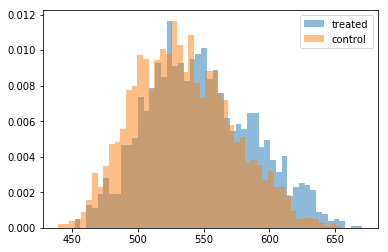

In [18]:
plt.hist(Y_all[T_all==1], alpha = 0.5,label='treated', bins=50, normed=True)
plt.hist(Y_all[T_all==0], alpha = 0.5,label='control', bins=50, normed=True)
plt.legend()
plt.show()

In [19]:
# nothing screwed up here
assert(set(urban[rural_filter]) == set([1,3]))
assert(set(urban[urban_filter]) == set([2,4]))

In [20]:
# checked
X_rural = X_all[rural_filter]
X_urban = X_all[urban_filter]

# checked
T_rural = T_all[rural_filter]
T_urban = T_all[urban_filter]

#checked
Y_rural = Y_all[rural_filter]
Y_urban = Y_all[urban_filter] # + 20*(2*T_all[urban_filter]-1) # checked


#checked
X_rural_control = X_rural[T_rural==0]
X_rural_treated = X_rural[T_rural==1]

#checked
X_urban_control = X_urban[T_urban==0]
X_urban_treated = X_urban[T_urban==1]

#checked
Y_rural_control = Y_rural[T_rural==0]
Y_rural_treated = Y_rural[T_rural==1]

#checked
Y_urban_control = Y_urban[T_urban==0]
Y_urban_treated = Y_urban[T_urban==1]

/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/kallus/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


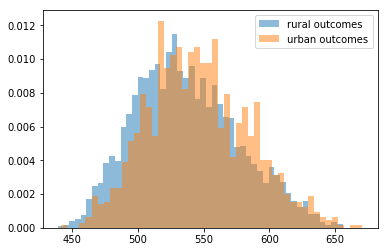

In [21]:
plt.hist(Y_rural, bins=50, alpha=0.5, label='rural outcomes', normed=True)
plt.hist(Y_urban, bins=50, alpha=0.5, label='urban outcomes', normed=True)
plt.legend()
plt.show()

In [22]:
assert X_rural_treated.shape[0] == Y_rural_treated.shape[0], (X_rural_treated.shape[0], Y_rural_treated.shape[0])

In [23]:
X_all.shape, X_rural.shape, X_urban.shape, Y_all.shape, Y_rural.shape, Y_urban.shape

((4218, 310), (2811, 310), (1407, 310), (4218,), (2811,), (1407,))

In [24]:
X_rural[T_rural ==1 ].shape

(1199, 310)

In [25]:
X_urban[T_urban ==1 ].shape

(606, 310)

In [26]:
X_rural_control.shape, X_urban_control.shape

((1612, 310), (801, 310))

In [27]:
X_rural_treated.shape, X_urban_treated.shape

((1199, 310), (606, 310))

In [28]:
_mean_outcome = np.mean(Y_all)
_mean_outcome
_propensity_all = np.sum(T_all)/T_all.shape[0]

In [29]:
def ite_adjusted_outcome(Y,T,_propensity, c = _mean_outcome):
    assert(_propensity>0)
    assert(_propensity<1)
    assert(len(Y.shape) == 1)
    assert(Y.shape == T.shape )
    _ite = np.zeros(Y.shape)
    _ite[T==1] =  (Y[T==1]- c)/_propensity
    _ite[T==0] = -(Y[T==0] - c)/(1-_propensity)
    return _ite

In [30]:
_cf_num_threads = 1

In [ ]:
gt_cf_all_ite_model = cf(X_all,
                         Y_all.reshape(-1,1),
                         T_all.astype(np.int).reshape(-1,1),
                         num_trees=5000,
                         tune_parameters=True,
                         num_threads = _cf_num_threads)
# baseline_ite_model = cf(X_all, Y_all.reshape(-1,1), T_all.astype(np.int).reshape(-1,1), num_trees=2000)

gt_cf_all_ite_all = np.array(grf.predict_causal_forest(gt_cf_all_ite_model, X_all,
                                                       num_threads = _cf_num_threads)[0]).ravel()

In [ ]:
plt.hist(ite_adjusted_outcome(Y_all - 10*gt_cf_all_ite_all, T_all, _propensity_all, c = _mean_outcome), bins=50)
plt.show()

plt.hist(ite_adjusted_outcome(Y_all, T_all, _propensity_all, c = _mean_outcome), bins = 50)
plt.show()

In [ ]:
rewrewrew

#  RCT OBS split

In [92]:
"""
X_rct = half of X_rural

T_rct = same half but of T_rural
Y_rct = same half but of Y_rural

X_rural_not_rct = X_rural \ X_rct
X_obs_treated_urban = half of X_urban_treated
X_obs_control_rural = half of X_rural_not_RCT_control

X_rct = 

X_obs = half of urban treated +
        all of urban control +
        half or non RCT rural control + 
        all of non RCT rural treated

X_obs = (X_rural_not_RCT_treated, X_obs_treated_urban, X_obs_control_rural, X_urban_control)
T_obs = (1*X_rural_treated.shape, 1*X_obs_treated_urban.shape, 0*X_obs_control_rural.shape, 0*X_urban_control.shape)

^^^ OLD SPLIT

New confounding:
1. top half of urban treated thrown away
2. top half of non-RCT rural treated also thrown away
3. something along these lines: like move both urban and rural treated in the same way
4. make size thrown away a parameter
"""

_keep_size = 0.5

#splitting rural in half
X_rct, X_rural_not_RCT, Y_rct, Y_rural_not_RCT, T_rct, T_rural_not_rct = train_test_split(X_rural,
                                                                                          Y_rural,
                                                                                          T_rural,
                                                                                          test_size = 0.5) # checked


#checked
X_rural_not_RCT_treated = X_rural_not_RCT[T_rural_not_rct==1]
X_rural_not_RCT_control = X_rural_not_RCT[T_rural_not_rct==0]

#checked
Y_rural_not_RCT_treated = Y_rural_not_RCT[T_rural_not_rct==1]
Y_rural_not_RCT_control = Y_rural_not_RCT[T_rural_not_rct==0]


# OUTCOME BASED REMOVAL METHOD
_treated_rural_median = np.median(Y_rural_not_RCT_treated)
_treated_urban_median = np.median(Y_urban_treated)

_treated_rural_filter = Y_rural_not_RCT_treated<_treated_rural_median
_treated_urban_filter = Y_urban_treated<_treated_urban_median

# remov
X_obs_treated_urban = X_urban_treated[_treated_urban_filter,:]
X_obs_treated_rural = X_rural_not_RCT_treated[_treated_rural_filter,:]

Y_obs_treated_urban = Y_urban_treated[_treated_urban_filter]
Y_obs_treated_rural = Y_rural_not_RCT_treated[_treated_rural_filter]


#checked
X_obs = np.vstack((X_obs_treated_rural,
                   X_obs_treated_urban,
                   X_rural_not_RCT_control,
                   X_urban_control))

#checked
Y_obs = np.vstack((Y_obs_treated_rural.reshape(-1,1),
                   Y_obs_treated_urban.reshape(-1,1),
                   Y_rural_not_RCT_control.reshape(-1,1),
                   Y_urban_control.reshape(-1,1))).ravel()

#checked
T_obs = np.array([1]*int(Y_obs_treated_rural.shape[0] + Y_obs_treated_urban.shape[0]) + 
                 [0]*int(Y_rural_not_RCT_control.shape[0] + Y_urban_control.shape[0]))


#checked
# X_obs_treated_urban, X_drop_obs_treated_urban, Y_obs_treated_urban, Y_drop_obs_treated_urban = train_test_split(X_urban_treated,
#                                                                                                                 Y_urban_treated,
#                                                                                                                 test_size = _keep_size)


# #checked
# X_obs_control_rural, X_drop_obs_control_rural, Y_obs_control_rural, Y_drop_obs_control_rural = train_test_split(X_rural_not_RCT_control,
#                                                                                                                 Y_rural_not_RCT_control,
#                                                                                                                 test_size = _keep_size)

# #checked
# X_obs = np.vstack((X_rural_not_RCT_treated,
#                    X_obs_treated_urban,
#                    X_obs_control_rural,
#                    X_urban_control))

# #checked
# Y_obs = np.vstack((Y_rural_not_RCT_treated.reshape(-1,1),
#                    Y_obs_treated_urban.reshape(-1,1),
#                    Y_obs_control_rural.reshape(-1,1),
#                    Y_urban_control.reshape(-1,1))).ravel()

# #checked
# T_obs = np.array([1]*int(Y_rural_not_RCT_treated.shape[0] + Y_obs_treated_urban.shape[0]) + 
#                  [0]*int(Y_obs_control_rural.shape[0] + Y_urban_control.shape[0]))

In [93]:
X_rural.shape[0]*0.2


562.2

In [94]:
X_all[np.random.randint(X_all.shape[0], size=80)].shape

(80, 310)

In [95]:
def _generate_rct_obs(X_rural, Y_rural, T_rural, X_urban, Y_urban, T_urban, rct_fraction_of_rural = 0.5, eval_fraction_of_notrct = 0.4):
    #splitting rural into rct and not rct
    # checked
    """
    X_rural -> X_rct + X_rural_not_RCT
    
    X_rural_not_RCT + X_urban -> X_notrct
    
    X_notrct -> X_eval + X_noteval
    
    X_noteval -> X_noteval_urban + X_noteval_rural
    
    X_noteval_urban is further curropted
    
    
    """
    X_rct, X_rural_not_RCT, Y_rct, Y_rural_not_RCT, T_rct, T_rural_not_rct = train_test_split(X_rural,
                                                                                              Y_rural,
                                                                                              T_rural,
                                                                                              test_size = rct_fraction_of_rural) 
    #checked
    X_notrct = np.vstack((X_rural_not_RCT, X_urban))
    Y_notrct = np.hstack((Y_rural_not_RCT, Y_urban))
    T_notrct = np.hstack((T_rural_not_rct, T_urban))
    _local_rural_filter = np.array([True]*X_rural_not_RCT.shape[0] + [False]*X_urban.shape[0]).ravel()
    assert(_local_rural_filter.shape == Y_notrct.shape)
    
    X_eval, X_noteval, Y_eval, Y_noteval, T_eval, T_noteval, _local_rural_filter_eval, _local_rural_filter_noteval = train_test_split(X_notrct, Y_notrct, T_notrct, _local_rural_filter, test_size = 1 - eval_fraction_of_notrct) 
    
    X_noteval_rural = X_noteval[_local_rural_filter_noteval]
    Y_noteval_rural = Y_noteval[_local_rural_filter_noteval]
    T_noteval_rural = T_noteval[_local_rural_filter_noteval]
    
    # checked
    X_noteval_rural_treated = X_noteval_rural[T_noteval_rural==1]
    X_noteval_rural_control = X_noteval_rural[T_noteval_rural==0]
        
    #checked 
    Y_noteval_rural_treated = Y_noteval_rural[T_noteval_rural==1]
    Y_noteval_rural_control = Y_noteval_rural[T_noteval_rural==0]
    
    # OUTCOME BASED REMOVAL
    _treated_rural_filter = Y_noteval_rural_treated<np.median(Y_noteval_rural_treated)
    _treated_urban_filter = Y_urban_treated<np.median(Y_urban[T_urban==1])

    # remove large samples.
    X_obs_treated_rural = X_noteval_rural_treated[_treated_rural_filter,:]
    Y_obs_treated_rural = Y_noteval_rural_treated[_treated_rural_filter]
    
    X_obs_treated_urban = X_urban_treated[_treated_urban_filter,:]
    Y_obs_treated_urban = Y_urban_treated[_treated_urban_filter]
    
    
    assert(X_obs_treated_rural.shape[0] == Y_obs_treated_rural.shape[0])

    #checked
    X_obs = np.vstack((X_obs_treated_rural,
                       X_obs_treated_urban,
                       X_noteval_rural_control,
                       X_urban_control))

    #checked
    Y_obs = np.vstack((Y_obs_treated_rural.reshape(-1,1),
                       Y_obs_treated_urban.reshape(-1,1),
                       Y_noteval_rural_control.reshape(-1,1),
                       Y_urban_control.reshape(-1,1))).ravel()

    #checked
    T_obs = np.array([1]*int(Y_obs_treated_rural.shape[0] + Y_obs_treated_urban.shape[0]) + 
                     [0]*int(Y_noteval_rural_control.shape[0] + Y_urban_control.shape[0]))
    
    assert(Y_eval.shape == T_eval.shape)
    assert(Y_rct.shape == T_rct.shape)
    assert(Y_obs.shape == Y_obs.shape)
    assert(X_rct.shape[0] == T_rct.shape[0])
    assert(X_obs.shape[0] == T_obs.shape[0])
    assert(X_eval.shape[0] == T_eval.shape[0])
    
    return X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_eval, Y_eval, T_eval

In [96]:
[ item.shape for item in _generate_rct_obs(X_rural, Y_rural, T_rural, X_urban, Y_urban, T_urban, rct_fraction_of_rural = 0.5, eval_fraction_of_notrct = 0.4)]

[(1405, 310),
 (1405,),
 (1405,),
 (1750, 310),
 (1750,),
 (1750,),
 (1125, 310),
 (1125,),
 (1125,)]

In [97]:
X_rural.shape

(2811, 310)

In [98]:
# # X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_not_rct, Y_not_rct, T_not_rct = _generate_rct_obs(X_rural,
#                                                                                               Y_rural,
#                                                                                               T_rural,
#                                                                                               X_urban,
#                                                                                              Y_urban,
#                                                                                              T_urban)

In [99]:
Y_rural_not_RCT.shape, Y_urban.shape

((1406,), (1407,))

In [100]:
X_not_rct = np.vstack((X_rural_not_RCT, X_urban))
Y_not_rct = np.hstack((Y_rural_not_RCT, Y_urban))
T_not_rct = np.hstack((T_rural_not_rct, T_urban))

In [101]:
Y_not_rct.shape, T_not_rct.shape

((2813,), (2813,))

In [102]:
Y_obs_treated_rural.shape, Y_rural_not_RCT_treated.shape

((289,), (583,))

In [103]:
Y_rct.shape

(1405,)

In [104]:
np.mean(Y_rct), np.mean(Y_obs) , np.mean(Y_all)

(536.2329774614473, 531.0579121540312, 540.0987829935199)

In [105]:
np.std(Y_rct), np.std(Y_rural_not_RCT) , np.std(Y_rural)

(38.938586200915196, 39.96875809969279, 39.467645802145995)

In [106]:
print([item.shape for item in (X_rct, X_rural_not_RCT, Y_rct, Y_rural_not_RCT, T_rct, T_rural_not_rct)])

[(1405, 310), (1406, 310), (1405,), (1406,), (1405,), (1406,)]


In [107]:
assert X_obs.shape[0] == Y_obs.shape[0], (X_obs.shape[0], Y_obs.shape[0])
assert X_obs.shape[0] == T_obs.shape[0], (X_obs.shape[0], T_obs.shape[0])
print('X_obs.shape', X_obs.shape)
print('Y_obs.shape', Y_obs.shape)
print('T_obs.shape', T_obs.shape)

assert X_rct.shape[0] == Y_rct.shape[0]
assert X_rct.shape[0] == T_rct.shape[0]
print('X_rct.shape', X_rct.shape)
print('Y_rct.shape', Y_rct.shape)
print('T_rct.shape', T_rct.shape)



X_obs.shape (2216, 310)
Y_obs.shape (2216,)
T_obs.shape (2216,)
X_rct.shape (1405, 310)
Y_rct.shape (1405,)
T_rct.shape (1405,)


In [108]:
print('treated std', np.std(Y_all[T_all==1]))
print('control std', np.std(Y_all[T_all==0]))

treated std 40.31223525890279
control std 37.52658889734035


# ALL GROUND TRUTH

In [109]:
_propensity_all = np.sum(T_all)/T_all.shape[0]

In [110]:
_propensity_all = np.sum(T_all)/T_all.shape[0]
gt_adjusted_ite_all = ite_adjusted_outcome(Y_all, T_all, _propensity= _propensity_all)
gt_adjusted_ite_obs = ite_adjusted_outcome(Y_obs, T_obs, _propensity= _propensity_all)
gt_adjusted_ite_rct = ite_adjusted_outcome(Y_rct, T_rct, _propensity= _propensity_all)
gt_adjusted_ite_urban = ite_adjusted_outcome(Y_urban, T_urban, _propensity= _propensity_all)

In [146]:
gt_adjusted_not_rct = ite_adjusted_outcome(Y_not_rct, 
                                           T_not_rct,
                                           _propensity= _propensity_all)

rmse(gt_adjusted_not_rct, _eta_model_2step.predict(X_not_rct) + omega_not_rct_pred_2step)

NameError: name '_eta_model_2step' is not defined

In [112]:
plt.hist(_eta_model_2step.predict(X_not_rct), bins = 50)
plt.show()

plt.hist(omega_not_rct_pred_2step, bins = 50)
plt.show()

NameError: name '_eta_model_2step' is not defined

In [113]:
print('GROUND TRUTH adjusted ite')
print('CF on OBS vs. 2 step with CF on ALL')

_ite_rmse(gt_adjusted_not_rct, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_not_rct, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_not_rct),
          omega_not_rct_pred_2step)

print()
print('GROUND TRUTH adjusted ite')
print('CF on RCT vs. 2 step with CF on ALL')

_ite_rmse(gt_adjusted_not_rct, # trained on whole dataset. ground truth
          _baseline_cf_RCT_ite_not_rct, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_not_rct),
          omega_not_rct_pred_2step)

GROUND TRUTH adjusted ite
CF on OBS vs. 2 step with CF on ALL


NameError: name '_ite_rmse' is not defined

In [115]:
gt_cf_all_ite_model = cf(X_all,
                         Y_all.reshape(-1,1),
                         T_all.astype(np.int).reshape(-1,1),
                         num_trees=5000,
                         tune_parameters=True,
                         num_threads = _cf_num_threads)
# baseline_ite_model = cf(X_all, Y_all.reshape(-1,1), T_all.astype(np.int).reshape(-1,1), num_trees=2000)
gt_cf_all_ite_obs = np.array(grf.predict_causal_forest(gt_cf_all_ite_model, X_obs,
                                                       num_threads = _cf_num_threads)[0]).ravel()
gt_cf_all_ite_rct = np.array(grf.predict_causal_forest(gt_cf_all_ite_model, X_rct,
                                                       num_threads = _cf_num_threads)[0]).ravel()
gt_cf_all_ite_all = np.array(grf.predict_causal_forest(gt_cf_all_ite_model, X_all,
                                                       num_threads = _cf_num_threads)[0]).ravel()
gt_cf_all_ite_urban = np.array(grf.predict_causal_forest(gt_cf_all_ite_model, X_urban,
                                                       num_threads = _cf_num_threads)[0]).ravel()

In [116]:
# get_best_model_from_gridcv(X_all,Y_all, reg_parameter_pairs + linear_reg_parameter_pairs, verbose=1)

In [117]:
gt_f1_obs_ite_model = get_best_model_from_gridcv(X_all[T_all==1],Y_all[T_all==1] , reg_parameter_pairs + linear_reg_parameter_pairs, verbose=1)
gt_f0_obs_ite_model = get_best_model_from_gridcv(X_all[T_all==0],Y_all[T_all==0] , reg_parameter_pairs + linear_reg_parameter_pairs)
# baseline_ite_model = cf(X_all, Y_all.reshape(-1,1), T_all.astype(np.int).reshape(-1,1), num_trees=2000)

gt_regressed_ite_obs = gt_f1_obs_ite_model.predict(X_obs).ravel() - gt_f0_obs_ite_model.predict(X_obs).ravel()
gt_regressed_ite_rct = gt_f1_obs_ite_model.predict(X_rct).ravel() - gt_f0_obs_ite_model.predict(X_rct).ravel()
gt_regressed_ite_all = gt_f1_obs_ite_model.predict(X_all).ravel() - gt_f0_obs_ite_model.predict(X_all).ravel()
gt_regressed_ite_urban = gt_f1_obs_ite_model.predict(X_urban).ravel() - gt_f0_obs_ite_model.predict(X_urban).ravel()
# _baseline_adjusted_ite_rct = _baseline_adjusted_obs_ite_model.predict(X_rct)
# _baseline_adjusted_ite_all = _baseline_adjusted_obs_ite_model.predict(X_all)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  36 out of  36 | elapsed:    3.8s finished


Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  11 out of  30 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    2.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   6 out of  12 | elapsed:    0.0s remaining:    0.0s


Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 45 candidates, totalling 90 fits


[Parallel(n_jobs=10)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:    6.9s finished


Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  14 out of  16 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  16 out of  16 | elapsed:    0.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False) val rmse:12.415891120397207


In [118]:
np.std(gt_cf_all_ite_all), np.std(gt_adjusted_ite_all), np.std(gt_regressed_ite_obs)

(1.623257167374289, 79.20299797687596, 24.914851374981847)

In [119]:
# IF BART AS A BASELINE, then use BART THROUGHOUT

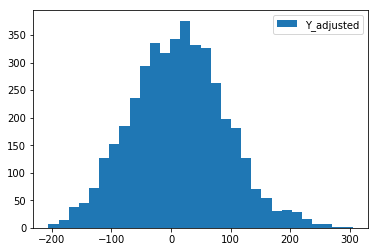

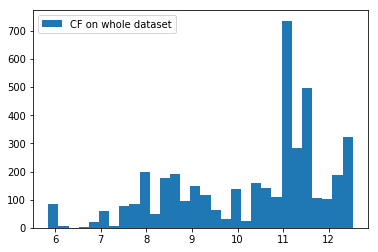

In [120]:
# plt.hist(gt_regressed_ite_all, bins=30,label='simple regression')
# plt.legend()
# plt.show()

plt.hist(gt_adjusted_ite_all, bins=30,label='Y_adjusted')
plt.legend()
plt.show()

plt.hist(gt_cf_all_ite_all, bins=30,label='CF on whole dataset')
plt.legend()
plt.show()

# BASELINES

## baseline: fit Y_adj on the obs data

In [121]:
#  _baseline_adjusted_obs_ite_model = get_best_model_from_gridcv(X_obs, 
#                                                                ite_adjusted_outcome(Y_obs, 
#                                                                                     T_obs,
#                                                                                     _propensity=_propensity_all), 
#                                                                reg_parameter_pairs,
#                                                                verbose=1)
# # baseline_ite_model = cf(X_all, Y_all.reshape(-1,1), T_all.astype(np.int).reshape(-1,1), num_trees=2000)
# _baseline_adjusted_ite_obs = _baseline_adjusted_obs_ite_model.predict(X_obs)
# _baseline_adjusted_ite_rct = _baseline_adjusted_obs_ite_model.predict(X_rct)
# _baseline_adjusted_ite_all = _baseline_adjusted_obs_ite_model.predict(X_all)
# _baseline_adjusted_ite_urban = _baseline_adjusted_obs_ite_model.predict(X_urban)

In [122]:
np.std(ite_adjusted_outcome(Y_obs, T_obs, _propensity=_propensity_all)), rmse(ite_adjusted_outcome(Y_obs, T_obs, _propensity=_propensity_all), _baseline_adjusted_ite_obs)

NameError: name '_baseline_adjusted_ite_obs' is not defined

In [123]:
plt.hist(_baseline_adjusted_ite_all, bins=50, label='Y_adj, fit on OBS, pred on OBS')
plt.legend()
plt.show()


NameError: name '_baseline_adjusted_ite_all' is not defined

# baseline: CF (2000 trees) only on OBS

In [124]:
_ite_obs_model = cf(X_obs,
               Y_obs.reshape(-1,1),
               T_obs.astype(np.int).reshape(-1,1), num_trees=5000, tune_parameters=True)
# baseline_ite_model = cf(X_all, Y_all.reshape(-1,1), T_all.astype(np.int).reshape(-1,1), num_trees=2000)
_baseline_cf_OBS_ite_obs = np.array(grf.predict_causal_forest(_ite_obs_model,  X_obs)[0]).ravel()
_baseline_cf_OBS_ite_rct = np.array(grf.predict_causal_forest(_ite_obs_model,  X_rct)[0]).ravel()
_baseline_cf_OBS_ite_all = np.array(grf.predict_causal_forest(_ite_obs_model,  X_all)[0]).ravel()
_baseline_cf_OBS_ite_urban = np.array(grf.predict_causal_forest(_ite_obs_model,  X_urban)[0]).ravel()

# baseline: CF (2000 trees) only on RCT

In [125]:
_ite_rct_model = cf(X_rct,
               Y_rct.reshape(-1,1),
               T_rct.astype(np.int).reshape(-1,1), num_trees=5000, tune_parameters=True)
# baseline_ite_model = cf(X_all, Y_all.reshape(-1,1), T_all.astype(np.int).reshape(-1,1), num_trees=2000)
_baseline_cf_rct_ite_obs = np.array(grf.predict_causal_forest(_ite_rct_model,  X_obs)[0]).ravel()
_baseline_cf_rct_ite_rct = np.array(grf.predict_causal_forest(_ite_rct_model,  X_rct)[0]).ravel()
_baseline_cf_rct_ite_all = np.array(grf.predict_causal_forest(_ite_rct_model,  X_all)[0]).ravel()
_baseline_cf_rct_ite_urban = np.array(grf.predict_causal_forest(_ite_rct_model,  X_urban)[0]).ravel()

In [126]:
def _ite_rmse(ite, _baseline_ite, eta_pred, omega_pred):
    assert(eta_pred.shape ==  omega_pred.shape)
    assert(ite.shape ==  _baseline_ite.shape)
    assert(ite.shape ==  omega_pred.shape)
    print('method 1 ite rmse: ', rmse(ite, _baseline_ite))
    print('method 2 ite rmse: ', rmse(ite, eta_pred + omega_pred))

In [127]:
def run_allregression_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs):
    assert(X_rct.shape[0] == Y_rct.shape[0])
    assert(T_rct.shape[0] == Y_rct.shape[0])
    assert(X_obs.shape[0] == Y_obs.shape[0])
    assert(T_obs.shape[0] == Y_obs.shape[0])
    # ^^^ IGNORE. just sanity checks 
    
    # 2 regressions on the obs data for OMEGA
    _best_f1_reg = get_best_model_from_gridcv(X_obs[T_obs==1], Y_obs[T_obs==1], reg_parameter_pairs)
    _best_f0_reg = get_best_model_from_gridcv(X_obs[T_obs==0], Y_obs[T_obs==0], reg_parameter_pairs)
    omega_obs_pred = _best_f1_reg.predict(X_obs).ravel() - _best_f0_reg.predict(X_obs).ravel() 
    omega_all_pred = _best_f1_reg.predict(X_all).ravel() - _best_f0_reg.predict(X_all).ravel() 
    omega_notrct_pred = _best_f1_reg.predict(X_not_rct).ravel() - _best_f0_reg.predict(X_not_rct).ravel() 
    
    # IGNORE. just sanity checks 
    assert(Y_obs.shape == omega_obs_pred.shape)
    
    # 2 regressions on the rct data for TAU
    # NOTE: this is only linear regs
    _best_f1_rct_reg = get_best_model_from_gridcv(X_rct[T_rct==1], Y_rct[T_rct==1], reg_parameter_pairs)
    _best_f0_rct_reg = get_best_model_from_gridcv(X_rct[T_rct==0], Y_rct[T_rct==0], reg_parameter_pairs)
    
    omega_rct_pred = _best_f1_reg.predict(X_rct).ravel() - _best_f0_reg.predict(X_rct).ravel()
    assert(omega_rct_pred.shape == Y_rct.shape)
    eta_rct_pred = _best_f1_rct_reg.predict(X_rct).ravel() - _best_f0_rct_reg.predict(X_rct).ravel() - omega_rct_pred
    
    _best_eta_reg = get_best_model_from_gridcv(X_rct, eta_rct_pred, linear_reg_parameter_pairs)
    
    return copy.deepcopy(_best_eta_reg), omega_obs_pred, omega_all_pred, omega_notrct_pred

In [128]:
_eta_pred_model_allreg, _omega_obs_pred_allreg, _omega_all_pred_allreg, _omega_notrct_pred_allreg = run_allregression_method(X_rct, Y_rct, T_rct, X_obs,  Y_obs, T_obs)



/scratch/apm470/pfrl-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [129]:
print('GROUND TRUTH regressed ITE')
print()
print('CF on OBS vs. all regressions on OBS')
_ite_rmse(gt_regressed_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_pred_model_allreg.predict(X_obs), 
          _omega_obs_pred_allreg)
print()
print('CF on OBS vs. all regressions on ALL')

_ite_rmse(gt_regressed_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_all, # trained only on obs data after the confounding
          _eta_pred_model_allreg.predict(X_all), 
          _omega_all_pred_allreg)

print()
print('CF on RCT vs. all regressions on ALL')

_ite_rmse(gt_regressed_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_pred_model_allreg.predict(X_obs), 
          _omega_obs_pred_allreg)

GROUND TRUTH regressed ITE

CF on OBS vs. all regressions on OBS
method 1 ite rmse:  30.657201635341124
method 2 ite rmse:  22.114358412706025

CF on OBS vs. all regressions on ALL
method 1 ite rmse:  37.54374409632222
method 2 ite rmse:  23.66542082214918

CF on RCT vs. all regressions on ALL
method 1 ite rmse:  25.395255251410674
method 2 ite rmse:  22.114358412706025


In [130]:
'CF on all vs. Y_adj, on all', rmse(gt_adjusted_ite_all, gt_cf_all_ite_all)

('CF on all vs. Y_adj, on all', 79.14075259074676)

In [131]:
'CF on all vs. Y_adj, on OBS', rmse(gt_adjusted_ite_obs, gt_cf_all_ite_obs)

('CF on all vs. Y_adj, on OBS', 69.49335878476855)

In [132]:
print('GROUND TRUTH Y_adj')
print()
print('CF on OBS vs. all regressions on OBS')
_ite_rmse(gt_adjusted_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_pred_model_allreg.predict(X_obs), 
          _omega_obs_pred_allreg)
print()
print('CF on RCT vs. all regressions on OBS')

_ite_rmse(gt_adjusted_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_pred_model_allreg.predict(X_obs), 
          _omega_obs_pred_allreg)

print()
print('CF on RCT vs. all regressions on ALL')

_ite_rmse(gt_adjusted_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_pred_model_allreg.predict(X_all),
          _omega_all_pred_allreg)

print()
print('CF on RCT vs. all regressions on NOT RCT')

rmse(gt_adjusted_not_rct, _eta_pred_model_allreg.predict(X_not_rct) + _omega_notrct_pred_allreg)


GROUND TRUTH Y_adj

CF on OBS vs. all regressions on OBS
method 1 ite rmse:  65.4726759609998
method 2 ite rmse:  65.30216375189177

CF on RCT vs. all regressions on OBS
method 1 ite rmse:  68.55810408505143
method 2 ite rmse:  65.30216375189177

CF on RCT vs. all regressions on ALL
method 1 ite rmse:  79.29181112996544
method 2 ite rmse:  75.93873678492

CF on RCT vs. all regressions on NOT RCT


76.93398411871611

In [133]:
print('RMSE of CF on RCT on OBS')
_ite_rmse(gt_cf_all_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_pred_model_allreg.predict(X_obs), 
          _omega_obs_pred_allreg)
print()
print('CF on OBS vs. all regressions on ALL')
_ite_rmse(gt_regressed_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_all, # trained only on obs data after the confounding
          _eta_pred_model_allreg.predict(X_all), 
          _omega_all_pred_allreg)

RMSE of CF on RCT on OBS
method 1 ite rmse:  27.80451076649255
method 2 ite rmse:  13.682628333529086

CF on OBS vs. all regressions on ALL
method 1 ite rmse:  37.54374409632222
method 2 ite rmse:  23.66542082214918


In [134]:
def run_2step_with_ite_with_interaction_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs):
    assert(X_rct.shape[0] == Y_rct.shape[0])
    assert(T_rct.shape[0] == Y_rct.shape[0])
    assert(X_obs.shape[0] == Y_obs.shape[0])
    assert(T_obs.shape[0] == Y_obs.shape[0])
    
    omega_obs_model = get_best_model_from_gridcv(covar_and_interaction_term(X_obs, T_obs),
                                                 Y_obs,
                                                 linear_reg_parameter_pairs,
                                                 print_flag=True)
    omega_rct_pred = omega_obs_model.predict(covar_and_interaction_term(X_rct, np.ones((X_rct.shape[0],)))).ravel() - omega_obs_model.predict(covar_and_interaction_term(X_rct, np.zeros((X_rct.shape[0],)))).ravel()
    omega_all_pred = omega_obs_model.predict(covar_and_interaction_term(X_all, np.ones((X_all.shape[0],)))).ravel() - omega_obs_model.predict(covar_and_interaction_term(X_all, np.zeros((X_all.shape[0],)))).ravel()
    # omega_obs_model.predict(covar_and_interaction_term(X_rct, np.ones((X_rct.shape[0],)))).ravel() - omega_obs_model.predict(covar_and_interaction_term(X_rct, np.zeros((X_rct.shape[0],)))).ravel()
    # omega_obs_model.predict(X_rct)
    _propensity_rct = np.sum(T_rct)/T_rct.shape[0]
    cate_rct_est = ite_adjusted_outcome(Y_rct, T_rct, _propensity=_propensity_rct) # CHECKED
    # 2*np.multiply(Y_rct, 2*T_rct-1).ravel() # change var name
    # omega  and cate_rct_est should both have a shape (n_rct,)
    assert(cate_rct_est.shape == omega_rct_pred.shape)
    print(np.std(2*Y_rct), np.std(cate_rct_est), np.std(omega_rct_pred))
    eta_rct_est = cate_rct_est - omega_rct_pred
    assert(len(eta_rct_est.shape) == 1)
    
    best_eta_pred_model = get_best_model_from_gridcv(X_rct,eta_rct_est, linear_reg_parameter_pairs)
    omega_obs_pred = omega_obs_model.predict(covar_and_interaction_term(X_obs, np.ones((X_obs.shape[0],)))).ravel() - omega_obs_model.predict(covar_and_interaction_term(X_obs, np.zeros((X_obs.shape[0],)))).ravel()
    
    return copy.deepcopy(best_eta_pred_model), omega_obs_pred, omega_all_pred

In [135]:
_eta_model_2ste_with_int, omega_obs_pred_2step_with_int, omega_all_pred_2step_with_int = run_2step_with_ite_with_interaction_method(X_rct, Y_rct, T_rct,
                                                                                                        X_obs, Y_obs, T_obs)
# _eta_model_2ste_with_int = lambda x: _best_yt_pred_model.predict(covar_and_interaction_term(x, np.zeros((x.shape[0],)))) - _best_yt_pred_model.predict(covar_and_interaction_term(x, np.ones((x.shape[0],))))


trying  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, 
77.87717240183039 78.3021478906284 11.80796433066401


In [136]:
print('GROUND TRUTH Y_adj')
print()
print('CF on OBS vs. 2step with interaction on OBS')
_ite_rmse(gt_adjusted_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_obs),
          omega_obs_pred_2step_with_int)
print()
print('CF on RCT vs. 2step with interaction on OBS')

_ite_rmse(gt_adjusted_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_obs),
          omega_obs_pred_2step_with_int)

print()
print('CF on RCT vs. 2step with interaction on OBS')

_ite_rmse(gt_adjusted_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_all),
          omega_all_pred_2step_with_int)

GROUND TRUTH Y_adj

CF on OBS vs. 2step with interaction on OBS
method 1 ite rmse:  65.4726759609998
method 2 ite rmse:  65.73356593291548

CF on RCT vs. 2step with interaction on OBS
method 1 ite rmse:  68.55810408505143
method 2 ite rmse:  65.73356593291548

CF on RCT vs. 2step with interaction on OBS
method 1 ite rmse:  79.29181112996544
method 2 ite rmse:  72.66704079071981


In [137]:
print('GROUND TRUTH CF')
print()
print('CF on OBS vs. 2step with interaction on OBS')
_ite_rmse(gt_cf_all_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_obs),
          omega_obs_pred_2step_with_int)
print()
print('CF on RCT vs. 2step with interaction on OBS')

_ite_rmse(gt_cf_all_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_obs),
          omega_obs_pred_2step_with_int)

print()
print('CF on RCT vs. 2step with interaction on OBS')

_ite_rmse(gt_cf_all_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_all),
          omega_all_pred_2step_with_int)

GROUND TRUTH CF

CF on OBS vs. 2step with interaction on OBS
method 1 ite rmse:  27.80451076649255
method 2 ite rmse:  20.16126224173181

CF on RCT vs. 2step with interaction on OBS
method 1 ite rmse:  3.5176140559774765
method 2 ite rmse:  20.16126224173181

CF on RCT vs. 2step with interaction on OBS
method 1 ite rmse:  3.697837783439241
method 2 ite rmse:  22.620176584128092


In [138]:
print('GROUND TRUTH regressed ite')
print()
print('CF on OBS vs. 2step with interaction on OBS')
_ite_rmse(gt_regressed_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_obs),
          omega_obs_pred_2step_with_int)
print()
print('CF on RCT vs. 2step with interaction on OBS')

_ite_rmse(gt_regressed_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_obs),
          omega_obs_pred_2step_with_int)

print()
print('CF on RCT vs. 2step with interaction on OBS')

_ite_rmse(gt_regressed_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2ste_with_int.predict(X_all),
          omega_all_pred_2step_with_int)

GROUND TRUTH regressed ite

CF on OBS vs. 2step with interaction on OBS
method 1 ite rmse:  30.657201635341124
method 2 ite rmse:  27.91513817981817

CF on RCT vs. 2step with interaction on OBS
method 1 ite rmse:  25.395255251410674
method 2 ite rmse:  27.91513817981817

CF on RCT vs. 2step with interaction on OBS
method 1 ite rmse:  27.176713294195043
method 2 ite rmse:  27.650096537900513


In [139]:
np.std(gt_cf_all_ite_all)

1.623257167374289

In [140]:
# def run_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, _internal_X_not_rct):
#     assert(X_rct.shape[0] == Y_rct.shape[0])
#     assert(T_rct.shape[0] == Y_rct.shape[0])
#     assert(X_obs.shape[0] == Y_obs.shape[0])
#     assert(T_obs.shape[0] == Y_obs.shape[0])
#     _cf_model = cf(X_obs,
#                    Y_obs.reshape(-1,1),
#                    T_obs.astype(np.int).reshape(-1,1),
#                    num_trees=500,
#                    tune_parameters=True,
#                    num_threads = _cf_num_threads)
    
#     omega_rct_pred = np.array(grf.predict_causal_forest(_cf_model, X_rct)[0]).ravel()
#     omega_obs_pred = np.array(grf.predict_causal_forest(_cf_model, X_obs)[0]).ravel()
#     omega_all_pred = np.array(grf.predict_causal_forest(_cf_model, X_all)[0]).ravel()
#     omega_not_rct_pred = np.array(grf.predict_causal_forest(_cf_model, _internal_X_not_rct)[0]).ravel()
    
#     _propensity_rct = np.sum(T_rct)/T_rct.shape[0]
#     cate_rct_est = ite_adjusted_outcome(Y_rct, T_rct, _propensity=_propensity_rct) # CHECKED

#     # omega  and cate_rct_est should both have a shape (n_rct,)
#     assert(cate_rct_est.shape == omega_rct_pred.shape)
#     eta_rct_est = cate_rct_est - omega_rct_pred
#     assert(len(eta_rct_est.shape) == 1)
    
#     best_eta_est_linear = get_best_model_from_gridcv(X_rct, eta_rct_est, linear_reg_parameter_pairs)
    
#     return copy.deepcopy(best_eta_est_linear), omega_obs_pred, omega_all_pred, omega_not_rct_pred

In [141]:
def run_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, _internal_X_not_rct):
    assert(X_rct.shape[0] == Y_rct.shape[0])
    assert(T_rct.shape[0] == Y_rct.shape[0])
    assert(X_obs.shape[0] == Y_obs.shape[0])
    assert(T_obs.shape[0] == Y_obs.shape[0])
    
    f1_rfr_model = get_best_model_from_gridcv(X_obs[T_obs==1], Y_obs[T_obs==1], rfr_reg_parameter_pairs)
    f0_rfr_model = get_best_model_from_gridcv(X_obs[T_obs==0], Y_obs[T_obs==0], rfr_reg_parameter_pairs)
    
    omega_rct_pred = f1_rfr_model.predict(X_rct).ravel() - f0_rfr_model.predict(X_rct).ravel()
    omega_obs_pred = f1_rfr_model.predict(X_obs).ravel() - f0_rfr_model.predict(X_obs).ravel()
    omega_all_pred = f1_rfr_model.predict(X_all).ravel() - f0_rfr_model.predict(X_all).ravel()
    omega_not_rct_pred = f1_rfr_model.predict(_internal_X_not_rct).ravel() - f0_rfr_model.predict(_internal_X_not_rct).ravel()
    
    _propensity_rct = np.sum(T_rct)/T_rct.shape[0]
    cate_rct_est = ite_adjusted_outcome(Y_rct, T_rct, _propensity=_propensity_rct) # CHECKED

    # omega  and cate_rct_est should both have a shape (n_rct,)
    assert(cate_rct_est.shape == omega_rct_pred.shape)
    eta_rct_est = cate_rct_est - omega_rct_pred
    assert(len(eta_rct_est.shape) == 1)
    
    best_eta_est_linear = get_best_model_from_gridcv(X_rct, eta_rct_est, linear_reg_parameter_pairs)
    
    return copy.deepcopy(best_eta_est_linear), omega_obs_pred, omega_all_pred, omega_not_rct_pred

In [142]:
def run_method_ridge_omega(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, _internal_X_not_rct):
    assert(X_rct.shape[0] == Y_rct.shape[0])
    assert(T_rct.shape[0] == Y_rct.shape[0])
    assert(X_obs.shape[0] == Y_obs.shape[0])
    assert(T_obs.shape[0] == Y_obs.shape[0])
    
    f1_ridge_model = get_best_model_from_gridcv(X_obs[T_obs==1], Y_obs[T_obs==1], linear_reg_parameter_pairs)
    f0_ridge_model = get_best_model_from_gridcv(X_obs[T_obs==0], Y_obs[T_obs==0], linear_reg_parameter_pairs)
    
    omega_rct_pred = f1_ridge_model.predict(X_rct).ravel() - f0_ridge_model.predict(X_rct).ravel()
    omega_obs_pred = f1_ridge_model.predict(X_obs).ravel() - f0_ridge_model.predict(X_obs).ravel()
    omega_all_pred = f1_ridge_model.predict(X_all).ravel() - f0_ridge_model.predict(X_all).ravel()
    omega_not_rct_pred = f1_ridge_model.predict(_internal_X_not_rct).ravel() - f0_ridge_model.predict(_internal_X_not_rct).ravel()
    
    _propensity_rct = np.sum(T_rct)/T_rct.shape[0]
    cate_rct_est = ite_adjusted_outcome(Y_rct, T_rct, _propensity=_propensity_rct) # CHECKED

    # omega  and cate_rct_est should both have a shape (n_rct,)
    assert(cate_rct_est.shape == omega_rct_pred.shape)
    eta_rct_est = cate_rct_est - omega_rct_pred
    assert(len(eta_rct_est.shape) == 1)
    
    best_eta_est_linear = get_best_model_from_gridcv(X_rct, eta_rct_est, linear_reg_parameter_pairs)
    
    return copy.deepcopy(best_eta_est_linear), omega_obs_pred, omega_all_pred, omega_not_rct_pred

In [143]:
_eta_model_2step , omega_obs_pred_2step, omega_all_pred_2step, omega_not_rct_pred_2step = run_method(X_rct, Y_rct, T_rct, X_obs,  Y_obs, T_obs)
# 0.8140800290679538 10.825779370835095 0.06316849619889346

TypeError: run_method() missing 1 required positional argument: '_internal_X_not_rct'

In [147]:
print('GROUND TRUTH adjusted ite')
print()
print('CF on OBS vs. 2 step with CF on OBS')
_ite_rmse(gt_adjusted_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_obs),
          omega_obs_pred_2step)
print()
print('CF on RCT vs. 2 step with CF on OBS')

_ite_rmse(gt_adjusted_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_obs),
          omega_obs_pred_2step)

print()
print('CF on RCT vs. 2 step with CF on ALL')

_ite_rmse(gt_adjusted_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_all),
          omega_all_pred_2step)

GROUND TRUTH adjusted ite

CF on OBS vs. 2 step with CF on OBS


NameError: name '_eta_model_2step' is not defined

In [148]:
Y_adj_notrct = ite_adjusted_outcome(Y_not_rct, 
                                        T_not_rct,
                                        _propensity = _propensity_all)

rmse(Y_adj_notrct, _eta_model_2step.predict(X_not_rct) + omega_not_rct_pred_2step)

NameError: name '_eta_model_2step' is not defined

In [149]:
gt_adjusted_ite_obs.shape, _baseline_cf_OBS_ite_obs.shape, _eta_model_2step.predict(X_obs).shape, omega_obs_pred_2step.shape

NameError: name '_eta_model_2step' is not defined

In [150]:
print('GROUND TRUTH adjusted ite')
print()
print('CF on OBS vs. 2 step with CF on ALL')
_ite_rmse(gt_adjusted_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_all, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_all),
          omega_all_pred_2step)
print()
print('GROUND TRUTH adjusted ite')
print('CF on RCT vs. 2 step with CF on ALL')

_ite_rmse(gt_adjusted_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_all),
          omega_all_pred_2step)

print()
print('GROUND TRUTH regressed ite')
print('CF on RCT vs. 2 step with CF on ALL')

_ite_rmse(gt_regressed_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_all),
          omega_all_pred_2step)


print()
print('GROUND TRUTH cf on ALL ite')
print('CF on RCT vs. 2 step with CF on ALL')

_ite_rmse(gt_cf_all_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_all),
          omega_all_pred_2step)

GROUND TRUTH adjusted ite

CF on OBS vs. 2 step with CF on ALL


NameError: name '_eta_model_2step' is not defined

In [151]:
print('GROUND TRUTH regressed ite')
print()
print('CF on OBS vs. 2 step with CF on OBS')
_ite_rmse(gt_regressed_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_obs),
          omega_obs_pred_2step)
print()
print('CF on RCT vs. 2 step with CF on OBS')

_ite_rmse(gt_regressed_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_obs),
          omega_obs_pred_2step)

print()
print('CF on RCT vs. 2 step with CF on OBS')

_ite_rmse(gt_regressed_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_all),
          omega_all_pred_2step)

GROUND TRUTH regressed ite

CF on OBS vs. 2 step with CF on OBS


NameError: name '_eta_model_2step' is not defined

In [152]:
print('GROUND TRUTH CF on all')
print()
print('CF on OBS vs. 2 step with CF on OBS')
_ite_rmse(gt_cf_all_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_obs),
          omega_obs_pred_2step)
print()
print('CF on RCT vs. 2 step with CF on OBS')

_ite_rmse(gt_cf_all_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_obs),
          omega_obs_pred_2step)

print()
print('CF on RCT vs. 2 step with CF on OBS')

_ite_rmse(gt_cf_all_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_2step.predict(X_all),
          omega_all_pred_2step)

GROUND TRUTH CF on all

CF on OBS vs. 2 step with CF on OBS


NameError: name '_eta_model_2step' is not defined

In [153]:
def run_cf_3step_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs):
    assert(X_rct.shape[0] == Y_rct.shape[0])
    assert(T_rct.shape[0] == Y_rct.shape[0])
    assert(X_obs.shape[0] == Y_obs.shape[0])
    assert(T_obs.shape[0] == Y_obs.shape[0])
    _cf_model = cf(X_obs,
                   Y_obs.reshape(-1,1),
                   T_obs.astype(np.int).reshape(-1,1),
                   num_trees=5000,
                   tune_parameters=True)
    
    omega_rct_pred = np.array(grf.predict_causal_forest(_cf_model, X_rct)[0]).ravel()
    omega_obs_pred = np.array(grf.predict_causal_forest(_cf_model, X_obs)[0]).ravel()
    omega_all_pred = np.array(grf.predict_causal_forest(_cf_model, X_all)[0]).ravel()
    omega_notrct_pred = np.array(grf.predict_causal_forest(_cf_model, X_not_rct)[0]).ravel()
    
    # omega  and cate_rct_est should both have a shape (n_rct,)
    _rct_cf_model = cf(X_rct,
                       Y_rct.reshape(-1,1),
                       T_rct.astype(np.int).reshape(-1,1),
                       num_trees=5000,
                       tune_parameters=True)
    
    tau_rct_pred = np.array(grf.predict_causal_forest(_rct_cf_model, X_rct)[0]).ravel()
    # eta_rct_est = cate_rct_est - omega_rct_pred
    eta_rct_est = tau_rct_pred - omega_rct_pred
    assert(len(eta_rct_est.shape) == 1)
    
    best_eta_est_linear = get_best_model_from_gridcv(X_rct, eta_rct_est, linear_reg_parameter_pairs)
    return copy.deepcopy(best_eta_est_linear), omega_obs_pred, omega_all_pred, omega_notrct_pred

In [154]:
_eta_model_cf_3step , omega_obs_pred_cf_3step, omega_all_pred_cf_3step = run_cf_3step_method(X_rct, Y_rct, T_rct, X_obs,  Y_obs, T_obs)


ValueError: too many values to unpack (expected 3)

In [ ]:
print('GROUND TRUTH CF on all')
print()
print('CF on OBS vs. 3 step with CF on OBS')
_ite_rmse(gt_cf_all_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_obs),
          omega_obs_pred_cf_3step)
print()
print('CF on RCT vs. 3 step with CF on OBS')

_ite_rmse(gt_cf_all_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_obs),
          omega_obs_pred_cf_3step)

print()
print('CF on RCT vs. 3 step with CF on ALL')

_ite_rmse(gt_cf_all_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_all),
          omega_all_pred_cf_3step)

In [ ]:
print('GROUND TRUTH Y_adjusted')
print()
print('CF on OBS vs. 3 step with CF on OBS')
_ite_rmse(gt_adjusted_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_obs),
          omega_obs_pred_cf_3step)
print()
print('CF on RCT vs. 3 step with CF on OBS')

_ite_rmse(gt_adjusted_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_obs),
          omega_obs_pred_cf_3step)

print()
print('CF on RCT vs. 3 step with CF on ALL')

_ite_rmse(gt_adjusted_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_all),
          omega_all_pred_cf_3step)

In [ ]:
print('GROUND TRUTH regression on Y')
print()
print('CF on OBS vs. 3 step with CF on OBS')
_ite_rmse(gt_regressed_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_OBS_ite_obs, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_obs),
          omega_obs_pred_cf_3step)
print()
print('CF on RCT vs. 3 step with CF on OBS')

_ite_rmse(gt_regressed_ite_obs, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_obs, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_obs),
          omega_obs_pred_cf_3step)

print()
print('CF on RCT vs. 3 step with CF on ALL')

_ite_rmse(gt_regressed_ite_all, # trained on whole dataset. ground truth
          _baseline_cf_rct_ite_all, # trained only on obs data after the confounding
          _eta_model_cf_3step .predict(X_all),
          omega_all_pred_cf_3step)



RMSE table. All numbers reported on the OBS dataset

| truth: Y_adj| truth: CF on all | truth: regression on Y |
---| --- | --- | --- |
method 5 regression| 54.01 | 27.80 | 17.55 |
method 2step with int| 63.82 | 29.07| 31.10 |
method 2step with cf| 65.33 | 28.00 | 31.43 |
method 3step with cd| 70.41 | 3.35 | 26.42 |
baseline CF on RCT| 70.42 | 3.03 | 26.44 |
baseline CF on OBS| 69.76 | 2.72 | 26.43 |
truth: Y_adj (std: 70.28)| - | 70.20| 51.96  |
truth: CF on all (std: 1.20)| 70.20 | - | 26.41 |
truth: regression on Y (std: 26.56)| 51.96 | 26.41 | - |

In [ ]:
np.std(gt_cf_all_ite_obs), np.std(gt_regressed_ite_obs), np.std(gt_adjusted_ite_obs)

In [ ]:
'CF, regression on Y RMSE',rmse(gt_cf_all_ite_obs, gt_regressed_ite_obs)

In [ ]:
'CF, Y_adjusted RMSE',rmse(gt_cf_all_ite_obs, gt_adjusted_ite_obs)

In [ ]:
'regression on Y, Y_adjusted RMSE',rmse(gt_regressed_ite_obs, gt_adjusted_ite_obs)

In [ ]:
'CF, regression on Y RMSE',rmse(gt_cf_all_ite_obs, gt_adjusted_ite_obs)

In [ ]:
_ite_rmse(_adjusted_ite_obs,
          _baseline_ite_obs,
          _best_eta_reg_2step.predict(X_obs),
          omega_obs_pred_2step)

In [ ]:
plt.hist(_best_eta_reg_2step.predict(X_obs) + omega_obs_pred_2step, bins = 50, alpha=0.5, label='2 step predicted ITE')
plt.legend()
plt.show()
plt.hist(_best_eta_reg_cf_3step.predict(X_obs) + omega_obs_pred_cf_3step, bins = 50, alpha=0.5, label='3(CF on obs/rct) step predicted ITE')
plt.legend()
plt.show()

In [ ]:
print('CF on RCT v. 3 step method')
print('On the obs population')
print()
_ite_rmse(_adjusted_ite_obs,
          _baseline_adjusted_ite_obs,
          _eta_model_2ste_with_int.predict(X_obs),
          omega_obs_pred_2step_interaction)

In [ ]:
print('CF on RCT v. 3 step method')
print('On the urban population')
print()
_ite_rmse(_adjusted_ite_ur,
          _baseline_adjusted_ite_obs,
          _eta_model_2ste_with_int.predict(X_obs),
          omega_obs_pred_2step_interaction)

In [ ]:
_ite_rmse(_adjusted_ite_obs,
          _baseline_ite_obs,
           _best_eta_reg_cf_3step.predict(X_obs),
          omega_obs_pred_cf_3step)

In [ ]:
_ite_rmse(_adjusted_ite_urban,
          _baseline_adjusted_ite_urban,
           _best_eta_reg_cf_3step.predict(X_urban),
          _baseline_ite_urban)

In [ ]:
_ite_rmse(gt_adjusted_ite_urban,
          ite_urban,
           _best_eta_reg_cf_3step.predict(X_urban),
          _baseline_ite_urban)

In [ ]:
plt.hist(ite_urban, alpha=0.5, label='CF')
plt.hist(_adjusted_ite_urban, alpha=0.5, label='Y_adj')
plt.hist(gt_adjusted_ite_urban, alpha=0.5, label='Y_adj pred')
plt.legend()
plt.show()

In [ ]:
_ite_rmse(gt_regressed_ite_urban,
          _baseline_ite_urban,
           _best_eta_reg_cf_3step.predict(X_urban),
          _baseline_ite_urban)

In [ ]:
print('CF on RCT v. 2 step method')
print('On the urban population')
print()
_ite_rmse(gt_regressed_ite_urban,
          _baseline_rct_ite_urban,
           _best_eta_reg_2step.predict(X_urban),
          _baseline_ite_urban)

In [ ]:
np.std(gt_adjusted_ite_urban), np.std(gt_regressed_ite_urban)

In [ ]:
print('CF on RCT v. 3 step method')
print('On the urban population')
print()
_ite_rmse(ite_urban,
          _baseline_rct_ite_urban,
          _best_eta_reg_cf_3step.predict(X_urban),
          _baseline_ite_urban)

In [ ]:
plt.hist(_best_eta_reg_cf_3step.predict(X_urban),  bins=40)
plt.show()

In [ ]:
print('std of ite (CF on all) of urban population ',np.std(ite_urban))
print('std of ite (CF on all) of whole population ',np.std(ite_all))

In [ ]:
print('std of ite (regression) of urban population ',np.std(gt_regressed_ite_urban))
print('std of ite (regression) of whole population ',np.std(gt_regressed_ite_all))

In [ ]:
plt.hist(gt_regressed_ite_all, bins=40, alpha=0.5)
plt.show()

plt.hist(gt_regressed_ite_urban, bins=40, alpha=0.5)
plt.show()

In [ ]:
np.std(_baseline_adjusted_ite_all)

In [ ]:
'std of ite using CF on all', np.std(ite_all)

In [ ]:
print('std of ite adjusted outcome (all)', np.std(_adjusted_ite_all))
print('std of ite adjusted outcome (obs)', np.std(_adjusted_ite_obs))

In [ ]:
np.mean(Y_all[T_all==1]) - np.mean(Y_all[T_all==0])

In [ ]:
print('ATE from data   : ', np.mean(Y_all[T_all==1]) - np.mean(Y_all[T_all==0]))
print('2step cf ATE    : ', np.mean(_best_eta_reg_2step.predict(X_obs) + omega_obs_pred_2step))
print('2step interact  : ', np.mean(_eta_model_2ste_with_int.predict(X_obs) + omega_obs_pred_2step_interaction))
print('cf 5000 trees   : ', np.mean(omega_obs_pred_2step))
print('regressions     : ', np.mean(_omega_obs_pred_allreg))
print('4 regressions   : ', np.mean(_eta_pred_model_allreg.predict(X_obs).ravel() + _omega_obs_pred_allreg))
print('cf on obs       : ', np.mean(_baseline_ite_obs))
print('cf on rct       : ', np.mean(_baseline_rct_ite_obs))

In [ ]:
plt.hist(_baseline_rct_ite_obs, label='CF on RCT ite', alpha=0.5)
plt.hist(ite_obs, label='CF on all ite', alpha=0.5)
plt.legend()
plt.show()

# plt.hist(ite_obs)
# plt.show()

In [ ]:
plt.hist(ite_all, alpha=0.4, label='CF(all) on obs', normed=True, bins=30)
plt.hist(ite_rct, alpha=0.4, label='CF(all) on rct', normed=True, bins=30)
plt.legend()
plt.show()

In [ ]:
plt.hist(_baseline_ite_obs, bins=30)
plt.show()
plt.hist(_baseline_rct_ite_obs, bins=30)
plt.show()

In [ ]:
np.std(Y_all), np.std(Y_obs), np.std(Y_rct)

In [ ]:
rmse(_baseline_rct_ite_obs, ite_obs)

In [ ]:
_rc

In [ ]:
run_allregression_method?

In [36]:
_ite_all_model = cf(X_all,
                        Y_all.reshape(-1,1),
                        T_all.astype(np.int).reshape(-1,1),
                        num_trees=5000,
                        tune_parameters=True)

_baseline_cf_all_pred_all = np.array(grf.predict_causal_forest(_ite_all_model, X_all)[0]).ravel()

In [37]:
_best_rfr_ALL_model = get_best_model_from_gridcv(X_all, ite_adjusted_outcome(Y_all,
                                                                             T_all,
                                                                             _propensity = _propensity_all,
                                                                             c=_mean_outcome), rfr_reg_parameter_pairs, verbose=1)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=10)]: Done  14 out of  16 | elapsed:   14.1s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  16 out of  16 | elapsed:   17.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) val rmse:25.52289241701434


In [78]:
def get_best_rfr_difference_pred(X, Y, T, X_to_eval):
     
    f1_rfr_model = get_best_model_from_gridcv(X[T==1], Y[T==1], rfr_reg_parameter_pairs)
    f0_rfr_model = get_best_model_from_gridcv(X[T==0], Y[T==0], rfr_reg_parameter_pairs)
    
    omega_eval_pred = f1_rfr_model.predict(X_to_eval).ravel() - f0_rfr_model.predict(X_to_eval).ravel()
    
    return omega_eval_pred

def get_best_ridge_difference_pred(X, Y, T, X_to_eval):    
    f1_ridge_model = get_best_model_from_gridcv(X[T==1], Y[T==1], linear_reg_parameter_pairs)
    f0_ridge_model = get_best_model_from_gridcv(X[T==0], Y[T==0], linear_reg_parameter_pairs)
    
    omega_eval_pred = f1_ridge_model.predict(X_to_eval).ravel() - f0_ridge_model.predict(X_to_eval).ravel()    
    
    return omega_eval_pred

In [84]:
def _full_experiment(rct_fraction_of_rural = 0.5, storage_folder = None):
    # X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_not_rct, Y_not_rct, T_not_rct 
    X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_eval, Y_eval, T_eval = _generate_rct_obs(X_rural,
                                                                                                  Y_rural,
                                                                                                  T_rural,
                                                                                                  X_urban,
                                                                                                  Y_urban,
                                                                                              T_urban,
                                                                                                  rct_fraction_of_rural = rct_fraction_of_rural)

    _baseline_cf_ALL_pred_eval= np.array(grf.predict_causal_forest(_ite_all_model, X_eval)[0]).ravel()
    
    Y_adj_eval = ite_adjusted_outcome(Y_eval, T_eval, _propensity = _propensity_all, c = _mean_outcome)
    Y_adj_rct = ite_adjusted_outcome(Y_rct, T_rct, _propensity = _propensity_all, c=_mean_outcome)
    
    # RCT models
    _best_rct_rfr_adj_model = get_best_model_from_gridcv(X_rct, Y_adj_rct, rfr_reg_parameter_pairs)
    _best_rct_ridge_adj_model = get_best_model_from_gridcv(X_rct, Y_adj_rct, linear_reg_parameter_pairs)
    
    # rct preds
    _ite_pred_rct_rfr_adj = _best_rct_rfr_adj_model.predict(X_eval)
    _ite_pred_rct_ridge_adj = _best_rct_ridge_adj_model.predict(X_eval)  
    _ite_pred_rct_rfr_diff = get_best_rfr_difference_pred(X_rct, Y_rct, T_rct, X_eval)
    _ite_pred_rct_ridge_diff = get_best_ridge_difference_pred(X_rct, Y_rct, T_rct, X_eval)
    
    # obs preds
    _ite_pred_obs_rfr_diff = get_best_rfr_difference_pred(X_obs, Y_obs, T_obs, X_eval)
    _ite_pred_obs_ridge_diff = get_best_ridge_difference_pred(X_obs, Y_obs, T_obs, X_eval)
    
    # 2 step methods
    _eta_2step_model, _omega_obs_pred_2step, _omega_all_pred_2step, _omega_eval_pred_2step = run_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_eval)
    _eta_ridge_2step_model, _omega_obs_pred_ridge_2step, _omega_all_pred_ridge_2step, _omega_eval_pred_ridge_2step = run_method_with_ridge(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_eval)
    
    assert(_omega_eval_pred_2step.shape == _baseline_cf_ALL_pred_eval.shape)
    
    _tau_pred_eval_2step = _eta_2step_model.predict(X_eval).ravel() + _omega_eval_pred_2step.ravel()
    _tau_pred_eval_ridge_2step = _eta_ridge_2step_model.predict(X_eval).ravel() + _omega_eval_pred_ridge_2step.ravel()
    
    _error_rct_pred_eval = rmse(_best_rct_ridge_adj_model.predict(X_eval), Y_adj_eval)
    _error_obs_pred_eval = rmse(_ite_pred_obs_ridge_diff, Y_adj_eval)
    
    return {
        '2 step rfr':       rmse(Y_adj_eval, _tau_pred_eval_2step),
        '2 step ridge':     rmse(Y_adj_eval, _tau_pred_eval_ridge_2step),
        'ridge RCT':        rmse(Y_adj_eval, _ite_pred_rct_ridge_adj),
        'ridge DIFF(RCT) ': rmse(Y_adj_eval, _ite_pred_rct_rfr_diff),
        'RFR (RCT) ':       rmse(Y_adj_eval, _ite_pred_rct_rfr_adj),
        'RFR DIFF(RCT) ':   rmse(Y_adj_eval, _ite_pred_rct_rfr_diff),
        'ridge DIFF OBS':   rmse(Y_adj_eval, _ite_pred_obs_ridge_diff),
        'RFR DIFF(OBS)':    rmse(Y_adj_eval, _ite_pred_obs_rfr_diff),
        'RFR (ALL)':        rmse(Y_adj_eval, _best_rfr_ALL_model.predict(X_eval)),
        'CF on ALL':        rmse(Y_adj_eval, _baseline_cf_ALL_pred_eval),
        'std Y_adj': np.std(Y_adj_eval)
    }
    
#     return _results
    

In [93]:
# _result_list = []

for i in range(50):
    _result_list.append(_full_experiment(rct_fraction_of_rural=0.5))
    np.savez('result_with_EVALSET_all_baselines', _result_list)
    print(_result_list[-1])

{'2 step rfr': 74.15511314304062, '2 step ridge': 72.41221132351792, 'ridge RCT': 74.29296293448122, 'ridge DIFF(RCT) ': 77.62831218348074, 'RFR (RCT) ': 73.30387332796231, 'RFR DIFF(RCT) ': 77.62831218348074, 'ridge DIFF OBS': 82.34152268771842, 'RFR DIFF(OBS)': 83.1996233481951, 'RFR (ALL)': 25.490177949876472, 'CF on ALL': 78.02762767215846, 'std Y_adj': 78.086576723828}
{'2 step rfr': 77.52178274214269, '2 step ridge': 77.1568654871584, 'ridge RCT': 78.97209493076912, 'ridge DIFF(RCT) ': 82.57776988673369, 'RFR (RCT) ': 79.21426526415003, 'RFR DIFF(RCT) ': 82.57776988673369, 'ridge DIFF OBS': 86.29860808118926, 'RFR DIFF(OBS)': 86.79470648378376, 'RFR (ALL)': 25.472156946971065, 'CF on ALL': 81.70032493741407, 'std Y_adj': 81.55401630123772}
{'2 step rfr': 72.97491789814163, '2 step ridge': 72.00833003964487, 'ridge RCT': 73.80219949128755, 'ridge DIFF(RCT) ': 77.90396563353595, 'RFR (RCT) ': 74.3066323988928, 'RFR DIFF(RCT) ': 77.90396563353595, 'ridge DIFF OBS': 79.14882067136801

{'2 step rfr': 77.64847636345662, '2 step ridge': 76.03365294280242, 'ridge RCT': 77.84992940328178, 'ridge DIFF(RCT) ': 80.02801104637342, 'RFR (RCT) ': 76.89031337838365, 'RFR DIFF(RCT) ': 80.02801104637342, 'ridge DIFF OBS': 85.30917976722228, 'RFR DIFF(OBS)': 86.90466161905438, 'RFR (ALL)': 25.64695283821415, 'CF on ALL': 80.85949036214527, 'std Y_adj': 80.87190879468127}
{'2 step rfr': 75.92452918391498, '2 step ridge': 74.73314353434118, 'ridge RCT': 76.44994767693076, 'ridge DIFF(RCT) ': 79.50842768808104, 'RFR (RCT) ': 77.58032639145726, 'RFR DIFF(RCT) ': 79.50842768808104, 'ridge DIFF OBS': 84.67266313773828, 'RFR DIFF(OBS)': 86.15232692760893, 'RFR (ALL)': 25.610212381227043, 'CF on ALL': 79.52259522063012, 'std Y_adj': 79.38817494992948}
{'2 step rfr': 72.6162984245188, '2 step ridge': 74.12670715467097, 'ridge RCT': 75.7813849203114, 'ridge DIFF(RCT) ': 79.24519178898295, 'RFR (RCT) ': 76.00092221955558, 'RFR DIFF(RCT) ': 79.24519178898295, 'ridge DIFF OBS': 83.297377715899

{'2 step rfr': 73.45793529655377, '2 step ridge': 74.75915661366214, 'ridge RCT': 76.62723648685233, 'ridge DIFF(RCT) ': 80.32048820834785, 'RFR (RCT) ': 76.8569949316269, 'RFR DIFF(RCT) ': 80.32048820834785, 'ridge DIFF OBS': 86.03560734889535, 'RFR DIFF(OBS)': 84.59658450346136, 'RFR (ALL)': 25.722299128105472, 'CF on ALL': 80.26921084400603, 'std Y_adj': 80.11991957789927}
{'2 step rfr': 73.29481015012408, '2 step ridge': 73.16583715513495, 'ridge RCT': 74.9892483552622, 'ridge DIFF(RCT) ': 78.82176429080731, 'RFR (RCT) ': 73.75386830804402, 'RFR DIFF(RCT) ': 78.82176429080731, 'ridge DIFF OBS': 82.7380813877813, 'RFR DIFF(OBS)': 83.1924860749877, 'RFR (ALL)': 24.774376957093093, 'CF on ALL': 79.02687610583942, 'std Y_adj': 79.08391463172408}
{'2 step rfr': 74.37640963374233, '2 step ridge': 73.61991755913809, 'ridge RCT': 75.42922596831393, 'ridge DIFF(RCT) ': 78.78139699874542, 'RFR (RCT) ': 75.37685743495095, 'RFR DIFF(RCT) ': 78.78139699874542, 'ridge DIFF OBS': 83.2017430469316

In [95]:
clean_results('result_with_EVALSET_all_baselines.npz')

2 step rfr        : 74.44 +/- 0.20
2 step ridge      : 74.05 +/- 0.15
ridge RCT         : 75.83 +/- 0.15
ridge DIFF(RCT)   : 79.14 +/- 0.15
RFR (RCT)         : 76.23 +/- 0.17
RFR DIFF(RCT)     : 79.14 +/- 0.15
ridge DIFF OBS    : 83.76 +/- 0.19
RFR DIFF(OBS)     : 84.15 +/- 0.23
RFR (ALL)         : 25.28 +/- 0.06
CF on ALL         : 79.07 +/- 0.14
std Y_adj         : 79.05 +/- 0.14


In [96]:
_result_list_04 = []

for i in range(100):
    _result_list_04.append(_full_experiment(rct_fraction_of_rural=0.6))
    np.savez('result_with_EVALSET_all_baselines_04RCT', _result_list_04)
    print(_result_list_04[-1])


{'2 step rfr': 74.10565490830638, '2 step ridge': 72.83631534918382, 'ridge RCT': 74.45714175805057, 'ridge DIFF(RCT) ': 77.57010302015168, 'RFR (RCT) ': 74.5378261416923, 'RFR DIFF(RCT) ': 77.57010302015168, 'ridge DIFF OBS': 82.49666777328233, 'RFR DIFF(OBS)': 84.19305378642683, 'RFR (ALL)': 24.753475346424082, 'CF on ALL': 77.3948246797411, 'std Y_adj': 77.38433131526013}
{'2 step rfr': 70.83559074857757, '2 step ridge': 72.50204470389949, 'ridge RCT': 74.11475312450986, 'ridge DIFF(RCT) ': 78.32698534713906, 'RFR (RCT) ': 73.2516598653161, 'RFR DIFF(RCT) ': 78.32698534713906, 'ridge DIFF OBS': 82.26185485053855, 'RFR DIFF(OBS)': 80.66405130274727, 'RFR (ALL)': 24.66325323148562, 'CF on ALL': 77.52675785701462, 'std Y_adj': 77.55678574162192}
{'2 step rfr': 76.7087693936295, '2 step ridge': 74.99731020892223, 'ridge RCT': 76.94603140604298, 'ridge DIFF(RCT) ': 80.88183519716462, 'RFR (RCT) ': 77.923578792163, 'RFR DIFF(RCT) ': 80.88183519716462, 'ridge DIFF OBS': 84.51619410144629, 

{'2 step rfr': 77.92561213890968, '2 step ridge': 76.34755598384075, 'ridge RCT': 77.87553236510587, 'ridge DIFF(RCT) ': 80.14064030888507, 'RFR (RCT) ': 77.97870252526958, 'RFR DIFF(RCT) ': 80.14064030888507, 'ridge DIFF OBS': 85.29160267694216, 'RFR DIFF(OBS)': 87.0439885227471, 'RFR (ALL)': 26.108468816043185, 'CF on ALL': 80.48701209272542, 'std Y_adj': 80.5032371077187}
{'2 step rfr': 77.1523876752494, '2 step ridge': 75.67655635916891, 'ridge RCT': 77.53405002813507, 'ridge DIFF(RCT) ': 81.3684644404566, 'RFR (RCT) ': 77.70166287965161, 'RFR DIFF(RCT) ': 81.3684644404566, 'ridge DIFF OBS': 86.57795945805726, 'RFR DIFF(OBS)': 88.07732271722587, 'RFR (ALL)': 25.998990020263236, 'CF on ALL': 81.43275727514003, 'std Y_adj': 81.40963949024112}
{'2 step rfr': 76.71181718743604, '2 step ridge': 75.55254993070537, 'ridge RCT': 77.13016652819664, 'ridge DIFF(RCT) ': 79.97076008368612, 'RFR (RCT) ': 77.62687942807068, 'RFR DIFF(RCT) ': 79.97076008368612, 'ridge DIFF OBS': 85.01029286646691

{'2 step rfr': 76.88597060601887, '2 step ridge': 75.0339605311843, 'ridge RCT': 77.15833897638387, 'ridge DIFF(RCT) ': 80.60621277482694, 'RFR (RCT) ': 76.47207754290177, 'RFR DIFF(RCT) ': 80.60621277482694, 'ridge DIFF OBS': 85.54733520318149, 'RFR DIFF(OBS)': 83.87833101315836, 'RFR (ALL)': 24.971083094249376, 'CF on ALL': 80.68528644459083, 'std Y_adj': 80.68011700333719}
{'2 step rfr': 75.20251164461332, '2 step ridge': 73.36828796372497, 'ridge RCT': 75.06666771174369, 'ridge DIFF(RCT) ': 77.49185785154972, 'RFR (RCT) ': 75.47883137524938, 'RFR DIFF(RCT) ': 77.49185785154972, 'ridge DIFF OBS': 83.39990182353665, 'RFR DIFF(OBS)': 85.2761141396061, 'RFR (ALL)': 25.335842783034376, 'CF on ALL': 78.38389121525535, 'std Y_adj': 78.46305449322433}
{'2 step rfr': 74.02200626548743, '2 step ridge': 72.77055162847094, 'ridge RCT': 74.38368993300381, 'ridge DIFF(RCT) ': 77.22248775725382, 'RFR (RCT) ': 73.26892685219272, 'RFR DIFF(RCT) ': 77.22248775725382, 'ridge DIFF OBS': 80.92438472847

{'2 step rfr': 77.06818945383755, '2 step ridge': 75.84190447693474, 'ridge RCT': 77.5243658021672, 'ridge DIFF(RCT) ': 80.91689710062315, 'RFR (RCT) ': 78.60172519182635, 'RFR DIFF(RCT) ': 80.91689710062315, 'ridge DIFF OBS': 86.19428247209096, 'RFR DIFF(OBS)': 87.73615331559292, 'RFR (ALL)': 26.006694388468357, 'CF on ALL': 80.65316167239982, 'std Y_adj': 80.58780501784564}
{'2 step rfr': 76.34821386685205, '2 step ridge': 74.93317241203576, 'ridge RCT': 76.65175182259762, 'ridge DIFF(RCT) ': 80.46651091837778, 'RFR (RCT) ': 77.94872558902158, 'RFR DIFF(RCT) ': 80.46651091837778, 'ridge DIFF OBS': 85.17597797469028, 'RFR DIFF(OBS)': 86.94171353996397, 'RFR (ALL)': 25.557898697294032, 'CF on ALL': 79.790390202086, 'std Y_adj': 79.59457002723538}
{'2 step rfr': 75.59477956880555, '2 step ridge': 73.90789478375102, 'ridge RCT': 75.86176286122482, 'ridge DIFF(RCT) ': 79.40331212301297, 'RFR (RCT) ': 76.3093192804343, 'RFR DIFF(RCT) ': 79.40331212301297, 'ridge DIFF OBS': 83.3670933475138

{'2 step rfr': 75.32252814119376, '2 step ridge': 73.78548972146436, 'ridge RCT': 75.63510151203698, 'ridge DIFF(RCT) ': 77.8316247237529, 'RFR (RCT) ': 76.04990594192981, 'RFR DIFF(RCT) ': 77.8316247237529, 'ridge DIFF OBS': 82.32574196510784, 'RFR DIFF(OBS)': 83.85447274480877, 'RFR (ALL)': 24.994415088693525, 'CF on ALL': 77.19180680526735, 'std Y_adj': 77.15483031826855}
{'2 step rfr': 74.76375708337162, '2 step ridge': 73.20438881207899, 'ridge RCT': 74.8895123865271, 'ridge DIFF(RCT) ': 77.30192554363701, 'RFR (RCT) ': 73.60657732066602, 'RFR DIFF(RCT) ': 77.30192554363701, 'ridge DIFF OBS': 79.45318775678797, 'RFR DIFF(OBS)': 81.27758512167381, 'RFR (ALL)': 25.364318046491917, 'CF on ALL': 77.44444659450744, 'std Y_adj': 77.45999182779427}
{'2 step rfr': 75.97194367724659, '2 step ridge': 73.97206890691002, 'ridge RCT': 75.87535811818357, 'ridge DIFF(RCT) ': 79.16841211953766, 'RFR (RCT) ': 76.63860912362598, 'RFR DIFF(RCT) ': 79.16841211953766, 'ridge DIFF OBS': 81.792659900920

FileNotFoundError: [Errno 2] No such file or directory: 'result_with_EVALSET_all_baselines_04RCT.np'

In [97]:
clean_results('result_with_EVALSET_all_baselines_04RCT.npz')

2 step rfr        : 75.48 +/- 0.16
2 step ridge      : 74.26 +/- 0.13
ridge RCT         : 75.98 +/- 0.14
ridge DIFF(RCT)   : 79.27 +/- 0.15
RFR (RCT)         : 76.09 +/- 0.16
RFR DIFF(RCT)     : 79.27 +/- 0.15
ridge DIFF OBS    : 83.70 +/- 0.18
RFR DIFF(OBS)     : 84.97 +/- 0.20
RFR (ALL)         : 25.21 +/- 0.05
CF on ALL         : 78.95 +/- 0.13
std Y_adj         : 78.93 +/- 0.13


In [98]:
_result_list_03 = []

for i in range(100):
    _result_list_03.append(_full_experiment(rct_fraction_of_rural=0.7))
    np.savez('result_with_EVALSET_all_baselines_03RCT', _result_list_03)
    print(_result_list_03[-1])

{'2 step rfr': 75.24327862305631, '2 step ridge': 73.6705064539643, 'ridge RCT': 75.44004536764288, 'ridge DIFF(RCT) ': 79.47029215599497, 'RFR (RCT) ': 75.58425399917215, 'RFR DIFF(RCT) ': 79.47029215599497, 'ridge DIFF OBS': 83.55236652485893, 'RFR DIFF(OBS)': 85.3045294780488, 'RFR (ALL)': 25.026436302242963, 'CF on ALL': 78.95300250312759, 'std Y_adj': 78.94292659849901}
{'2 step rfr': 77.63813169426776, '2 step ridge': 76.20601914031948, 'ridge RCT': 78.11040697439577, 'ridge DIFF(RCT) ': 81.0400022414609, 'RFR (RCT) ': 77.58328347613498, 'RFR DIFF(RCT) ': 81.0400022414609, 'ridge DIFF OBS': 85.0914193800192, 'RFR DIFF(OBS)': 86.92861636874864, 'RFR (ALL)': 25.343791189586273, 'CF on ALL': 80.49199304083606, 'std Y_adj': 80.48107471537959}
{'2 step rfr': 74.85443575483406, '2 step ridge': 73.24588203460888, 'ridge RCT': 74.78975408129632, 'ridge DIFF(RCT) ': 78.23906784512114, 'RFR (RCT) ': 74.97730394857415, 'RFR DIFF(RCT) ': 78.23906784512114, 'ridge DIFF OBS': 83.51927538864102

{'2 step rfr': 73.83335148016239, '2 step ridge': 74.92751888965483, 'ridge RCT': 76.43861544600837, 'ridge DIFF(RCT) ': 77.79426495253473, 'RFR (RCT) ': 75.81457213383932, 'RFR DIFF(RCT) ': 77.79426495253473, 'ridge DIFF OBS': 82.11241314475349, 'RFR DIFF(OBS)': 80.63285745253651, 'RFR (ALL)': 25.121214939754257, 'CF on ALL': 78.08021685294204, 'std Y_adj': 78.17306856038262}
{'2 step rfr': 75.5484119038535, '2 step ridge': 74.0508237668394, 'ridge RCT': 75.81204188855371, 'ridge DIFF(RCT) ': 79.6268814163964, 'RFR (RCT) ': 74.46062354574, 'RFR DIFF(RCT) ': 79.6268814163964, 'ridge DIFF OBS': 83.81725363301445, 'RFR DIFF(OBS)': 85.59242283814723, 'RFR (ALL)': 25.03414825508387, 'CF on ALL': 79.34365572074806, 'std Y_adj': 79.33034620730797}
{'2 step rfr': 75.76571244586368, '2 step ridge': 74.33875158102067, 'ridge RCT': 76.20365198749234, 'ridge DIFF(RCT) ': 78.47144707625688, 'RFR (RCT) ': 74.48462097813899, 'RFR DIFF(RCT) ': 78.47144707625688, 'ridge DIFF OBS': 82.39547225334186, '

{'2 step rfr': 71.4918068075577, '2 step ridge': 72.86582376604393, 'ridge RCT': 74.71893679424397, 'ridge DIFF(RCT) ': 78.54316959720383, 'RFR (RCT) ': 74.7676250407624, 'RFR DIFF(RCT) ': 78.54316959720383, 'ridge DIFF OBS': 82.38597216443435, 'RFR DIFF(OBS)': 81.1358974720883, 'RFR (ALL)': 24.464199605614187, 'CF on ALL': 77.45839697861759, 'std Y_adj': 77.53872737948596}
{'2 step rfr': 76.6652092503882, '2 step ridge': 74.90651349490332, 'ridge RCT': 76.71223598103228, 'ridge DIFF(RCT) ': 79.03533220335812, 'RFR (RCT) ': 76.93957745280703, 'RFR DIFF(RCT) ': 79.03533220335812, 'ridge DIFF OBS': 83.51166569030593, 'RFR DIFF(OBS)': 85.49715485166367, 'RFR (ALL)': 25.053621626957984, 'CF on ALL': 79.08965211471667, 'std Y_adj': 79.19965368146974}
{'2 step rfr': 76.7405145904864, '2 step ridge': 75.92502300092133, 'ridge RCT': 77.82355759141214, 'ridge DIFF(RCT) ': 80.56995323470768, 'RFR (RCT) ': 76.3113686611495, 'RFR DIFF(RCT) ': 80.56995323470768, 'ridge DIFF OBS': 84.89455237599347,

{'2 step rfr': 77.56599378083678, '2 step ridge': 75.99281092381723, 'ridge RCT': 77.79432897489959, 'ridge DIFF(RCT) ': 80.32205576571174, 'RFR (RCT) ': 77.76567364125786, 'RFR DIFF(RCT) ': 80.32205576571174, 'ridge DIFF OBS': 84.57768000985183, 'RFR DIFF(OBS)': 86.09513089265916, 'RFR (ALL)': 26.290495499154392, 'CF on ALL': 80.09590467420959, 'std Y_adj': 80.15901606813418}
{'2 step rfr': 75.7627897494255, '2 step ridge': 73.75466720161278, 'ridge RCT': 75.57751192443116, 'ridge DIFF(RCT) ': 77.82096701641376, 'RFR (RCT) ': 76.07045716905789, 'RFR DIFF(RCT) ': 77.82096701641376, 'ridge DIFF OBS': 83.66964537513974, 'RFR DIFF(OBS)': 85.46431833060052, 'RFR (ALL)': 23.795739234331954, 'CF on ALL': 77.85267046048459, 'std Y_adj': 77.77336809340653}
{'2 step rfr': 76.71740672391907, '2 step ridge': 74.94734383687023, 'ridge RCT': 76.85104768523617, 'ridge DIFF(RCT) ': 79.66291665829972, 'RFR (RCT) ': 76.3856784390803, 'RFR DIFF(RCT) ': 79.66291665829972, 'ridge DIFF OBS': 84.44643824640

{'2 step rfr': 74.98898936484711, '2 step ridge': 73.37873972048845, 'ridge RCT': 75.17226299279137, 'ridge DIFF(RCT) ': 78.20530202695954, 'RFR (RCT) ': 76.68275044433474, 'RFR DIFF(RCT) ': 78.20530202695954, 'ridge DIFF OBS': 83.07543064851836, 'RFR DIFF(OBS)': 84.91026515072204, 'RFR (ALL)': 24.77533836465477, 'CF on ALL': 77.64257576654059, 'std Y_adj': 77.60963224946751}
{'2 step rfr': 74.60003283186907, '2 step ridge': 73.06578511650845, 'ridge RCT': 74.7599419764272, 'ridge DIFF(RCT) ': 77.58080934687833, 'RFR (RCT) ': 75.10218800324152, 'RFR DIFF(RCT) ': 77.58080934687833, 'ridge DIFF OBS': 82.36776478502075, 'RFR DIFF(OBS)': 84.16858017038378, 'RFR (ALL)': 24.673654537833805, 'CF on ALL': 77.28957298369639, 'std Y_adj': 77.27966687893003}
{'2 step rfr': 76.68566838817, '2 step ridge': 75.2900633314009, 'ridge RCT': 76.9365896212617, 'ridge DIFF(RCT) ': 80.79388099395344, 'RFR (RCT) ': 77.26614571283378, 'RFR DIFF(RCT) ': 80.79388099395344, 'ridge DIFF OBS': 84.6664891882932, '

In [99]:
clean_results('result_with_EVALSET_all_baselines_03RCT.npz')

2 step rfr        : 76.48 +/- 0.15
2 step ridge      : 75.29 +/- 0.13
ridge RCT         : 77.07 +/- 0.13
ridge DIFF(RCT)   : 79.82 +/- 0.13
RFR (RCT)         : 76.77 +/- 0.16
RFR DIFF(RCT)     : 79.82 +/- 0.13
ridge DIFF OBS    : 84.23 +/- 0.15
RFR DIFF(OBS)     : 85.63 +/- 0.17
RFR (ALL)         : 25.23 +/- 0.05
CF on ALL         : 79.41 +/- 0.12
std Y_adj         : 79.41 +/- 0.12


In [100]:
_result_list_02 = []

for i in range(100):
    _result_list_02.append(_full_experiment(rct_fraction_of_rural=0.8))
    np.savez('result_with_EVALSET_all_baselines_02RCT', _result_list_02)
    print(_result_list_02[-1])

{'2 step rfr': 76.08796514833111, '2 step ridge': 74.32833017799805, 'ridge RCT': 76.25542962729662, 'ridge DIFF(RCT) ': 79.15359978626155, 'RFR (RCT) ': 80.68914635571072, 'RFR DIFF(RCT) ': 79.15359978626155, 'ridge DIFF OBS': 81.47511186736996, 'RFR DIFF(OBS)': 83.4669193297278, 'RFR (ALL)': 25.11121290742644, 'CF on ALL': 78.40805057302339, 'std Y_adj': 78.53627948653407}
{'2 step rfr': 79.59984652301438, '2 step ridge': 77.97669386112113, 'ridge RCT': 78.35472809136456, 'ridge DIFF(RCT) ': 80.58871542266814, 'RFR (RCT) ': 78.62470720097062, 'RFR DIFF(RCT) ': 80.58871542266814, 'ridge DIFF OBS': 86.39732066718925, 'RFR DIFF(OBS)': 87.69611711895483, 'RFR (ALL)': 25.384720870476734, 'CF on ALL': 79.6175357181442, 'std Y_adj': 79.29100189249662}
{'2 step rfr': 79.44345598651203, '2 step ridge': 77.15266960552165, 'ridge RCT': 78.5789109214116, 'ridge DIFF(RCT) ': 79.01597818376278, 'RFR (RCT) ': 79.45393831189814, 'RFR DIFF(RCT) ': 79.01597818376278, 'ridge DIFF OBS': 84.5440014621886

{'2 step rfr': 76.96766958353959, '2 step ridge': 75.75844545181039, 'ridge RCT': 77.11806529458283, 'ridge DIFF(RCT) ': 79.71713678949551, 'RFR (RCT) ': 77.84864592261277, 'RFR DIFF(RCT) ': 79.71713678949551, 'ridge DIFF OBS': 83.55398710170459, 'RFR DIFF(OBS)': 84.27818407013582, 'RFR (ALL)': 25.15890601934412, 'CF on ALL': 78.8381840272021, 'std Y_adj': 78.89417874014242}
{'2 step rfr': 77.9980026082553, '2 step ridge': 75.44139662077635, 'ridge RCT': 77.84909501340248, 'ridge DIFF(RCT) ': 79.13239511247964, 'RFR (RCT) ': 75.69444995556287, 'RFR DIFF(RCT) ': 79.13239511247964, 'ridge DIFF OBS': 81.33695411774923, 'RFR DIFF(OBS)': 83.72226883844591, 'RFR (ALL)': 25.00886732278481, 'CF on ALL': 77.67087767418715, 'std Y_adj': 77.6928051749982}
{'2 step rfr': 78.21314329263676, '2 step ridge': 76.62140044152608, 'ridge RCT': 78.16084094524956, 'ridge DIFF(RCT) ': 80.22702337348012, 'RFR (RCT) ': 77.42679539729279, 'RFR DIFF(RCT) ': 80.22702337348012, 'ridge DIFF OBS': 85.70978928703231

{'2 step rfr': 78.83751373805896, '2 step ridge': 76.91832159386429, 'ridge RCT': 78.85161411003678, 'ridge DIFF(RCT) ': 80.61247239011234, 'RFR (RCT) ': 77.90968468057031, 'RFR DIFF(RCT) ': 80.61247239011234, 'ridge DIFF OBS': 83.24868413312065, 'RFR DIFF(OBS)': 85.1086229979336, 'RFR (ALL)': 25.07057273246853, 'CF on ALL': 78.45407250484308, 'std Y_adj': 78.53099458357065}
{'2 step rfr': 80.00228764536382, '2 step ridge': 78.39657113793467, 'ridge RCT': 79.99655661418487, 'ridge DIFF(RCT) ': 81.29451261903716, 'RFR (RCT) ': 79.32287522095332, 'RFR DIFF(RCT) ': 81.29451261903716, 'ridge DIFF OBS': 84.31358563709065, 'RFR DIFF(OBS)': 86.09238792860992, 'RFR (ALL)': 25.524377680348334, 'CF on ALL': 80.61961343769063, 'std Y_adj': 80.7197387379283}
{'2 step rfr': 78.3552316064774, '2 step ridge': 76.47346712637396, 'ridge RCT': 78.27222920161238, 'ridge DIFF(RCT) ': 80.60532220931975, 'RFR (RCT) ': 77.44707277612501, 'RFR DIFF(RCT) ': 80.60532220931975, 'ridge DIFF OBS': 82.8909917041392

{'2 step rfr': 76.25667844439752, '2 step ridge': 74.3975709449141, 'ridge RCT': 76.43106801467061, 'ridge DIFF(RCT) ': 78.75749112082211, 'RFR (RCT) ': 75.87065463337866, 'RFR DIFF(RCT) ': 78.75749112082211, 'ridge DIFF OBS': 82.22516438498845, 'RFR DIFF(OBS)': 84.38085182539471, 'RFR (ALL)': 24.645394110182654, 'CF on ALL': 78.4157632817053, 'std Y_adj': 78.4597986749398}
{'2 step rfr': 76.8488446309751, '2 step ridge': 77.33223264240165, 'ridge RCT': 79.50758774794757, 'ridge DIFF(RCT) ': 79.67016787921054, 'RFR (RCT) ': 78.48051125854332, 'RFR DIFF(RCT) ': 79.67016787921054, 'ridge DIFF OBS': 84.56151794515428, 'RFR DIFF(OBS)': 83.41416465343981, 'RFR (ALL)': 25.86300266059925, 'CF on ALL': 79.60297591134307, 'std Y_adj': 79.58654597207692}
{'2 step rfr': 78.90759724572708, '2 step ridge': 77.1599245032706, 'ridge RCT': 78.94571443618108, 'ridge DIFF(RCT) ': 80.64143124333302, 'RFR (RCT) ': 79.3250420362448, 'RFR DIFF(RCT) ': 80.64143124333302, 'ridge DIFF OBS': 85.15355241748536, 

{'2 step rfr': 81.70806347313868, '2 step ridge': 79.4611284451745, 'ridge RCT': 81.1713967641159, 'ridge DIFF(RCT) ': 82.3334514727848, 'RFR (RCT) ': 78.05484545155589, 'RFR DIFF(RCT) ': 82.3334514727848, 'ridge DIFF OBS': 86.66522078442145, 'RFR DIFF(OBS)': 88.58133407465765, 'RFR (ALL)': 25.844146241242804, 'CF on ALL': 80.70690114891853, 'std Y_adj': 80.54839391476057}
{'2 step rfr': 76.38039273528778, '2 step ridge': 74.72863040334427, 'ridge RCT': 76.41957666367543, 'ridge DIFF(RCT) ': 79.1435720322274, 'RFR (RCT) ': 76.43116922555784, 'RFR DIFF(RCT) ': 79.1435720322274, 'ridge DIFF OBS': 82.09340816218702, 'RFR DIFF(OBS)': 83.91100245820212, 'RFR (ALL)': 24.55006862685897, 'CF on ALL': 77.46679576922917, 'std Y_adj': 77.5005052209357}
{'2 step rfr': 78.64680550151783, '2 step ridge': 76.93740380375942, 'ridge RCT': 77.88927935210289, 'ridge DIFF(RCT) ': 78.71569278657631, 'RFR (RCT) ': 77.96168895802617, 'RFR DIFF(RCT) ': 78.71569278657631, 'ridge DIFF OBS': 84.2610006184366, 'R

In [101]:
clean_results('result_with_EVALSET_all_baselines_02RCT.npz')

2 step rfr        : 78.08 +/- 0.16
2 step ridge      : 76.48 +/- 0.14
ridge RCT         : 78.31 +/- 0.14
ridge DIFF(RCT)   : 79.88 +/- 0.12
RFR (RCT)         : 78.05 +/- 0.18
RFR DIFF(RCT)     : 79.88 +/- 0.12
ridge DIFF OBS    : 83.86 +/- 0.13
RFR DIFF(OBS)     : 85.56 +/- 0.13
RFR (ALL)         : 25.22 +/- 0.04
CF on ALL         : 79.07 +/- 0.11
std Y_adj         : 79.08 +/- 0.11


In [102]:
_result_list_01 = []

for i in range(100):
    _result_list_01.append(_full_experiment(rct_fraction_of_rural=0.9))
    np.savez('result_with_EVALSET_all_baselines_01RCT', _result_list_01)
    print(_result_list_01[-1])
clean_results('result_with_EVALSET_all_baselines_01RCT.npz')

{'2 step rfr': 79.55963312827076, '2 step ridge': 78.1848413675763, 'ridge RCT': 79.23159564356132, 'ridge DIFF(RCT) ': 80.06715480440782, 'RFR (RCT) ': 80.49063289637373, 'RFR DIFF(RCT) ': 80.06715480440782, 'ridge DIFF OBS': 84.47956856360429, 'RFR DIFF(OBS)': 86.22456108768831, 'RFR (ALL)': 25.600349541786777, 'CF on ALL': 78.96813884402457, 'std Y_adj': 78.89317478266773}
{'2 step rfr': 78.54997826641606, '2 step ridge': 76.17692614553542, 'ridge RCT': 77.71109781705341, 'ridge DIFF(RCT) ': 78.5300968357387, 'RFR (RCT) ': 78.14395547207188, 'RFR DIFF(RCT) ': 78.5300968357387, 'ridge DIFF OBS': 83.28019564307789, 'RFR DIFF(OBS)': 82.5763241962018, 'RFR (ALL)': 25.405541626727562, 'CF on ALL': 77.48992482851699, 'std Y_adj': 77.4716278784975}
{'2 step rfr': 78.26125664768219, '2 step ridge': 76.41036349572299, 'ridge RCT': 78.60893698663291, 'ridge DIFF(RCT) ': 78.95437121285602, 'RFR (RCT) ': 79.33698934870507, 'RFR DIFF(RCT) ': 78.95437121285602, 'ridge DIFF OBS': 82.52300378525412

{'2 step rfr': 81.08211349628833, '2 step ridge': 79.29182070228276, 'ridge RCT': 81.1673185896297, 'ridge DIFF(RCT) ': 80.89330113843407, 'RFR (RCT) ': 84.84040497124651, 'RFR DIFF(RCT) ': 80.89330113843407, 'ridge DIFF OBS': 83.05299572652206, 'RFR DIFF(OBS)': 84.77399271531755, 'RFR (ALL)': 24.883697902049704, 'CF on ALL': 78.95237672317649, 'std Y_adj': 79.01960823979995}
{'2 step rfr': 78.52424421325088, '2 step ridge': 76.73633109447945, 'ridge RCT': 78.46429386369793, 'ridge DIFF(RCT) ': 79.94959427333056, 'RFR (RCT) ': 79.69297563394247, 'RFR DIFF(RCT) ': 79.94959427333056, 'ridge DIFF OBS': 83.2190903125831, 'RFR DIFF(OBS)': 84.68299173846026, 'RFR (ALL)': 25.254038594628188, 'CF on ALL': 78.48823888249508, 'std Y_adj': 78.49958239522209}
{'2 step rfr': 79.31536814955416, '2 step ridge': 77.26510281770025, 'ridge RCT': 78.61574755552196, 'ridge DIFF(RCT) ': 80.03254876857524, 'RFR (RCT) ': 80.3177132900345, 'RFR DIFF(RCT) ': 80.03254876857524, 'ridge DIFF OBS': 83.785138852344

{'2 step rfr': 80.4788067604556, '2 step ridge': 77.98925081726097, 'ridge RCT': 79.78416531170228, 'ridge DIFF(RCT) ': 80.43807519222084, 'RFR (RCT) ': 81.53547769170098, 'RFR DIFF(RCT) ': 80.43807519222084, 'ridge DIFF OBS': 82.89837055833776, 'RFR DIFF(OBS)': 85.45854448191534, 'RFR (ALL)': 25.155506872471, 'CF on ALL': 79.3319125527996, 'std Y_adj': 79.42471543420803}
{'2 step rfr': 78.81312196730747, '2 step ridge': 76.52078419518139, 'ridge RCT': 77.82777897673259, 'ridge DIFF(RCT) ': 77.57126399843983, 'RFR (RCT) ': 78.52293805445711, 'RFR DIFF(RCT) ': 77.57126399843983, 'ridge DIFF OBS': 83.00561716820076, 'RFR DIFF(OBS)': 85.28802581160119, 'RFR (ALL)': 24.639258189262417, 'CF on ALL': 77.69657507998159, 'std Y_adj': 77.7235381001743}
{'2 step rfr': 78.35113579752449, '2 step ridge': 76.37705841787283, 'ridge RCT': 77.60459618114825, 'ridge DIFF(RCT) ': 77.5286726119844, 'RFR (RCT) ': 80.21403190850457, 'RFR DIFF(RCT) ': 77.5286726119844, 'ridge DIFF OBS': 81.4823536861309, 'R

{'2 step rfr': 79.76874496468429, '2 step ridge': 77.62589057154622, 'ridge RCT': 79.38097144862282, 'ridge DIFF(RCT) ': 79.0218224269854, 'RFR (RCT) ': 79.53349766892082, 'RFR DIFF(RCT) ': 79.0218224269854, 'ridge DIFF OBS': 84.05797486389314, 'RFR DIFF(OBS)': 84.33915192715631, 'RFR (ALL)': 25.34536357507296, 'CF on ALL': 78.52593595612007, 'std Y_adj': 78.50744330450999}
{'2 step rfr': 80.64715536466169, '2 step ridge': 79.09021107466116, 'ridge RCT': 80.17665584932011, 'ridge DIFF(RCT) ': 81.33619612324799, 'RFR (RCT) ': 80.48880431536358, 'RFR DIFF(RCT) ': 81.33619612324799, 'ridge DIFF OBS': 84.48578725236028, 'RFR DIFF(OBS)': 86.2589159658206, 'RFR (ALL)': 25.723951314871485, 'CF on ALL': 80.03511853227982, 'std Y_adj': 80.07278711338991}
{'2 step rfr': 79.44676503039288, '2 step ridge': 77.66681329436395, 'ridge RCT': 79.4758643273698, 'ridge DIFF(RCT) ': 80.99582740124083, 'RFR (RCT) ': 81.10688012482696, 'RFR DIFF(RCT) ': 80.99582740124083, 'ridge DIFF OBS': 84.82610578882235

{'2 step rfr': 79.79939840158039, '2 step ridge': 77.71549704890614, 'ridge RCT': 80.00271667667032, 'ridge DIFF(RCT) ': 81.37004015297845, 'RFR (RCT) ': 81.2029181058054, 'RFR DIFF(RCT) ': 81.37004015297845, 'ridge DIFF OBS': 83.60465375389559, 'RFR DIFF(OBS)': 85.51728252312343, 'RFR (ALL)': 25.21894047733456, 'CF on ALL': 79.67286581962075, 'std Y_adj': 79.76614488171192}
{'2 step rfr': 82.09239163734605, '2 step ridge': 80.07170509949238, 'ridge RCT': 81.65689290255813, 'ridge DIFF(RCT) ': 81.79890390665071, 'RFR (RCT) ': 81.08287509809311, 'RFR DIFF(RCT) ': 81.79890390665071, 'ridge DIFF OBS': 86.72838799840335, 'RFR DIFF(OBS)': 88.71077688663492, 'RFR (ALL)': 25.375528647988496, 'CF on ALL': 80.67787730810593, 'std Y_adj': 80.51238454129908}
{'2 step rfr': 77.2081432549908, '2 step ridge': 75.17566511907009, 'ridge RCT': 77.58562896887666, 'ridge DIFF(RCT) ': 78.55379699259049, 'RFR (RCT) ': 78.46286300019442, 'RFR DIFF(RCT) ': 78.55379699259049, 'ridge DIFF OBS': 83.630294237467

In [53]:
[item['2 step'] for item in _result_list]

[74.6136452765414,
 74.52113509568767,
 74.3522571513946,
 75.14134184879391,
 73.86120784383706,
 72.40815125482808,
 75.3958321053442,
 75.36279881605658,
 74.13927843718741,
 72.49241595246558]

In [50]:
np.mean([item['2 step'] for item in _result_list]), np.std([item['2 step'] for item in _result_list])/10**0.5

(74.22880637821365, 0.31941175237773695)

In [57]:
np.mean([item['RFR on OBS'] for item in _result_list]), np.std([item['RFR on OBS'] for item in _result_list])/10**0.5

(83.67878681431229, 0.3309045806659721)

2 step rfr        : 74.11 +/- 0.28
2 step ridge      : 73.90 +/- 0.21
ridge RCT         : 75.67 +/- 0.21
ridge DIFF(RCT)   : 78.92 +/- 0.21
RFR (RCT)         : 76.18 +/- 0.23
RFR DIFF(RCT)     : 78.92 +/- 0.21
ridge DIFF OBS    : 83.67 +/- 0.24
RFR DIFF(OBS)     : 83.87 +/- 0.33
RFR (ALL)         : 25.28 +/- 0.08
CF on ALL         : 78.89 +/- 0.20
std Y_adj         : 78.88 +/- 0.20


In [2]:
def mean_sem(err_dict, method_name):
    err_list = [item[method_name] for item in err_dict]
    return (np.mean(err_list), np.std(err_list)/len(err_list)**0.5)

def clean_results(filename):
    errs_dict = np.load(filename)['arr_0']
    for method_name in errs_dict[0].keys():
        print('{:18}: {:2.2f} +/- {:2.2f}'.format(method_name, *mean_sem(errs_dict, method_name)))
        
def ret_row(filenames):
    err_list_dict = {}
    sem_list_dict = {}
    for filename in filenames:
        errs_dict = np.load(filename)['arr_0']
        for method_name in errs_dict[0].keys():
            # print('{:18}: {:2.2f} +/- {:2.2f}'.format(method_name, *mean_sem(errs_dict, method_name)))
            if err_list_dict.get(method_name, None) is None:
                err_list_dict[method_name] = []
                sem_list_dict[method_name] = []
            mean, sem = mean_sem(errs_dict, method_name)
            err_list_dict[method_name].append(mean)
            sem_list_dict[method_name].append(sem)
    return err_list_dict, sem_list_dict

In [160]:
_err_list_dict, _sem_list_dict = ret_row([
    'result_with_EVALSET_all_baselines_01RCT.npz',
    'result_with_EVALSET_all_baselines_02RCT.npz',
    'result_with_EVALSET_all_baselines_03RCT.npz',
    'result_with_EVALSET_all_baselines_04RCT.npz',
    'result_with_EVALSET_all_baselines.npz',
])

In [161]:
clean_results('result_with_EVALSET_all_baselines_01RCT.npz')

2 step rfr        : 79.74 +/- 0.13
2 step ridge      : 77.85 +/- 0.13
ridge RCT         : 79.48 +/- 0.12
ridge DIFF(RCT)   : 80.19 +/- 0.14
RFR (RCT)         : 80.57 +/- 0.15
RFR DIFF(RCT)     : 80.19 +/- 0.14
ridge DIFF OBS    : 83.89 +/- 0.15
RFR DIFF(OBS)     : 85.66 +/- 0.15
RFR (ALL)         : 25.19 +/- 0.04
CF on ALL         : 79.12 +/- 0.11
std Y_adj         : 79.14 +/- 0.11


In [162]:
_err_list_dict.keys()

dict_keys(['2 step rfr', '2 step ridge', 'ridge RCT', 'ridge DIFF(RCT) ', 'RFR (RCT) ', 'RFR DIFF(RCT) ', 'ridge DIFF OBS', 'RFR DIFF(OBS)', 'RFR (ALL)', 'CF on ALL', 'std Y_adj'])

In [163]:
import matplotlib

In [164]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf')

In [166]:
rct_frac_range = [0.1, 0.2, 0.3 , 0.4, 0.5]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

to_plot_list = ['2 step rfr', '2 step ridge', 'ridge RCT', 'ridge DIFF(RCT) ', 'RFR (RCT) ', 'RFR DIFF(RCT) ', 'ridge DIFF OBS', 'RFR DIFF(OBS)']
name_list = ['2 step RF', '2 step ridge', 'ridge $Y^{GT}$ (UNC)', 'ridge DIFF(UNC) ', 'RF $Y^{GT}$(UNC) ', 'RF DIFF(UNC) ', 'ridge DIFF(CONF)', 'RF DIFF(CONF)']
marker_list = ['o', 'd', '^', '>', '<', 'v', 'P','s']
linestyle_list = ['-', '-', '--', '--', '--', '--', '--','--']

plt.figure(figsize=(9,6), dpi=300)
for ind, plot_name in enumerate(to_plot_list):
    plt.errorbar(rct_frac_range,
                 _err_list_dict[plot_name],
                 yerr = 1.96*np.array(_sem_list_dict[plot_name]),
                 marker = marker_list[ind],
                 label = name_list[ind],
                 linewidth = 3,
                 linestyle = linestyle_list[ind],)
# plt.errorbar(rct_frac_range, _err_list_dict['2 step ridge'], yerr = 1.96*_sem_list_dict['2 step rfr'], marker = 'o',label='COLORR 0/1 Loss')
# plt.errorbar(rct_frac_range, _err_list_dict['2 step rfr'], yerr = 1.96*_sem_list_dict['2 step rfr'], marker = 'o',label='COLORR 0/1 Loss')
# plt.errorbar(rct_frac_range, _err_list_dict['2 step rfr'], yerr = 1.96*_sem_list_dict['2 step rfr'], marker = 'o',label='COLORR 0/1 Loss')
# plt.errorbar(rct_frac_range, _err_list_dict['2 step rfr'], yerr = 1.96*_sem_list_dict['2 step rfr'], marker = 'o',label='COLORR 0/1 Loss')
# plt.errorbar(rct_frac_range, _err_list_dict['2 step rfr'], yerr = 1.96*_sem_list_dict['2 step rfr'], marker = 'o',label='COLORR 0/1 Loss')
# plt.errorbar(rct_frac_range, _err_list_dict['2 step rfr'], yerr = 1.96*_sem_list_dict['2 step rfr'], marker = 'o',label='COLORR 0/1 Loss')
# plt.errorbar(rct_frac_range, _err_list_dict['2 step rfr'], yerr = 1.96*_sem_list_dict['2 step rfr'], marker = 'o',label='COLORR 0/1 Loss')
# plt.errorbar(noise_range, 1- temp_bart_acc_val_arr,yerr = 1.96*temp_bart_acc_val_sem_arr, marker = 'P',label='BART 0/1 Loss')
# plt.errorbar(noise_range, 1- np.array(xl_acc_val_arr),yerr = 1.96*xl_acc_val_sem_arr, marker = 'd',label='XL 0/1 Loss')
# plt.errorbar(noise_range, 1- np.array(GD_val_acc_noise_arr),yerr = 1.96*np.array(GD_val_acc_sem_noise_arr), marker = 's',label='GD 0/1 Loss')
# plt.errorbar(noise_range, cf_loss_arr,yerr = 1.96*cf_sem_arr, marker = '>',label='CF 0/1 Loss')
plt.xlabel('size of UNCONF as fraction of rural', fontsize=17)
plt.ylabel('RMSE on EVAL set', fontsize=17)
plt.xticks(rct_frac_range)
plt.yticks(list(range(73, 89, 3)))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 2700x1800 with 1 Axes>

In [167]:
clean_results('./result_with_cfall_RFR.npz')

2 step            : 68.55 +/- 0.18
RF on RCT         : 76.17 +/- 0.07
RFR on OBS        : 73.63 +/- 0.74
RFR on ALL        : 25.13 +/- 0.02
ridge RCT         : 75.73 +/- 0.05
ridge OBS         : 82.15 +/- 0.06
CF on ALL         : 78.73 +/- 0.04
std Y_adj         : 79.02 +/- 0.04


In [ ]:
clean_results('./result_with_cfall_RFR.npz')

In [ ]:
clean_results('./result_with_cfall_RFR_02_RCT.npz')

In [ ]:
clean_results('./result_with_cfall_RFR_03_RCT.npz')

In [ ]:
np.mean([item['std Y_adj'] for item in _result_list]), np.std([item['std Y_adj'] for item in _result_list])/10**0.5

In [ ]:
np.mean([item['CF on ALL rmse'] for item in _result_list]), np.std([item['CF on ALL rmse'] for item in _result_list])/10**0.5

In [ ]:
def run_linear_baseline(rct_fraction_of_rural = 0.5):
    X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_not_rct, Y_not_rct, T_not_rct = _generate_rct_obs(X_rural,
                                                                                                      Y_rural,
                                                                                                      T_rural,
                                                                                                      X_urban,
                                                                                                      Y_urban,
                                                                                                      T_urban,
                                                                                                      rct_fraction_of_rural = rct_fraction_of_rural)
    print(X_rct.shape, X_not_rct.shape)
#     _best_rct_linear_model = get_best_model_from_gridcv(X_rct, ite_adjusted_outcome(Y_rct,
#                                                                          T_rct,
#                                                                          _propensity = _propensity_all,
#                                                                          c=_mean_outcome), linear_reg_parameter_pairs)

#     _error_rct_pred_not_rct = rmse(_best_rct_linear_model.predict(X_not_rct), ite_adjusted_outcome(Y_not_rct,
#                                                                    T_not_rct, 
#                                                                    _propensity = _propensity_all,
#                                                                    c = _mean_outcome))

#     _best_obs_linear_model = get_best_model_from_gridcv(X_obs, ite_adjusted_outcome(Y_obs,
#                                                                          T_obs,
#                                                                          _propensity = _propensity_all,
#                                                                          c=_mean_outcome), linear_reg_parameter_pairs)

#     _error_obs_pred_not_rct = rmse(_best_obs_linear_model .predict(X_not_rct), ite_adjusted_outcome(Y_not_rct,
#                                                                    T_not_rct, 
#                                                                    _propensity = _propensity_all,
#                                                                    c = _mean_outcome))
    
#     return {'err_rct':_error_rct_pred_not_rct, 'err_obs': _error_obs_pred_not_rct}

In [ ]:
run_linear_baseline(0.8)

In [ ]:
X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_not_rct, Y_not_rct, T_not_rct = _generate_rct_obs(X_rural,
                                                                                                      Y_rural,
                                                                                                      T_rural,
                                                                                                      X_urban,
                                                                                                      Y_urban,
                                                                                                      T_urban,
                                                                                                      rct_fraction_of_rural = 0.5)

In [ ]:
_best_rct_linear_model = get_best_model_from_gridcv(X_rct, ite_adjusted_outcome(Y_rct,
                                                                         T_rct,
                                                                         _propensity = _propensity_all,
                                                                         c=_mean_outcome), linear_reg_parameter_pairs)
    
rmse(_best_rct_linear_model.predict(X_not_rct), ite_adjusted_outcome(Y_not_rct,
                                                                   T_not_rct, 
                                                                   _propensity = _propensity_all,
                                                                   c = _mean_outcome))

In [ ]:

_rfr_result_list = []
for i in range(10):
    _best_rct_rfr_model = get_best_model_from_gridcv(X_rct, ite_adjusted_outcome(Y_rct,
                                                                             T_rct,
                                                                             _propensity = _propensity_all,
                                                                             c=_mean_outcome), rfr_reg_parameter_pairs, verbose=1)

    _rfr_result_list.append(rmse(_best_rct_rfr_model.predict(X_not_rct), ite_adjusted_outcome(Y_not_rct,
                                                                       T_not_rct, 
                                                                       _propensity = _propensity_all,
                                                                       c = _mean_outcome)))

In [ ]:

_rfr_on_NOTRCT_result_list = []
for i in range(10):
    _best_notrct_rfr_model = get_best_model_from_gridcv(X_not_rct, ite_adjusted_outcome(Y_not_rct,
                                                                                        T_not_rct,
                                                                                        _propensity = _propensity_all,
                                                                                        c = np.mean(Y_not_rct)), 
                                                        rfr_reg_parameter_pairs, verbose=1)

    _rfr_on_NOTRCT_result_list.append(rmse(_best_notrct_rfr_model.predict(X_not_rct), 
                                           ite_adjusted_outcome(Y_not_rct,
                                                                T_not_rct, 
                                                                _propensity = _propensity_all,
                                                                c = _mean_outcome)))

In [ ]:
np.mean(_rfr_on_NOTRCT_result_list), np.std(_rfr_on_NOTRCT_result_list)/10**0.5

In [ ]:
_rfr_on_OBS_result_list = []
for i in range(10):
    _best_OBS_rfr_model = get_best_model_from_gridcv(X_obs, ite_adjusted_outcome(Y_obs,
                                                                                    T_obs,
                                                                                    _propensity = _propensity_all,
                                                                                    c = _mean_outcome), 
                                                        rfr_reg_parameter_pairs, verbose=0)

    _rfr_on_OBS_result_list.append(rmse(_best_OBS_rfr_model.predict(X_not_rct), 
                                           ite_adjusted_outcome(Y_not_rct,
                                                                T_not_rct, 
                                                                _propensity = _propensity_all,
                                                                c = _mean_outcome)))
    print(_rfr_on_OBS_result_list[-1])

In [ ]:
np.mean(_rfr_on_OBS_result_list), np.std(_rfr_on_OBS_result_list)/10**0.5

In [ ]:
_best_rct_f0_linear_model = get_best_model_from_gridcv(X_rct[T_rct==0], Y_rct[T_rct ==0], linear_reg_parameter_pairs)
_best_rct_f1_linear_model = get_best_model_from_gridcv(X_rct[T_rct==1], Y_rct[T_rct ==1], linear_reg_parameter_pairs)
    
rmse(_best_rct_f1_linear_model.predict(X_not_rct).ravel() - _best_rct_f0_linear_model.predict(X_not_rct).ravel(), 
     ite_adjusted_outcome(Y_not_rct, T_not_rct, _propensity = _propensity_all,
                                                                   c = _mean_outcome))

In [ ]:
plt.hist(ite_adjusted_outcome(Y_not_rct, T_not_rct, _propensity = _propensity_all,
                                                                   c = _mean_outcome) - _best_rct_f1_linear_model.predict(X_not_rct).ravel() + _best_rct_f0_linear_model.predict(X_not_rct).ravel(), bins=40)
plt.show()

In [ ]:
plt.hist(ite_adjusted_outcome(Y_not_rct, T_not_rct, _propensity = _propensity_all,
                                                                   c = _mean_outcome) - _best_rct_linear_model.predict(X_not_rct), bins=40)
plt.show()

In [ ]:
_linear_baseline_result = []
for i in range(10):
    _linear_baseline_result.append(run_linear_baseline(0.8))
    print(_linear_baseline_result[-1])

In [ ]:
np.mean([item['err_rct'] for item in _linear_baseline_result]), np.std([item['err_rct'] for item in _linear_baseline_result])/10**0.5

In [ ]:
np.mean([item['err_obs'] for item in _linear_baseline_result]), np.std([item['err_obs'] for item in _linear_baseline_result])/10**0.5

In [ ]:
np.mean(ite_adjusted_outcome(Y_all/10, T_all, _propensity=_propensity_all, c = _mean_outcome/10))

In [ ]:
np.mean(Y_all[T_all==1]) - np.mean(Y_all[T_all==0])